In [1]:
# AeroCNN-II with U-Net
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3281664699025551747
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10429530018183216057
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3515732066110784098
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 22722641920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 329189970777098336
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6"
 xla_global_i

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy(["/GPU:0","/GPU:1", "/GPU:2"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [4]:
n_kernel=50
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 101
strides = 1
input_size = 100

In [5]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [6]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133, 16, 1, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [12]:
image_np = image_df.iloc[:, :].values

In [13]:
image = image_np.reshape((133, 16, 100, 100))

In [14]:
image = 1-image/100

In [15]:
path = 'D:\\airfoilFlowField'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 0].values

In [17]:
data_name = path + '\\' + str(geometry_orig[0]) + "alpha"+ str(int(alpha[1])) + "_interpolated.csv"
print(data_name)

D:\airfoilFlowField\airfoil1alpha-8_interpolated.csv


In [18]:
Vmag_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        data_name = path + '\\' + str(geometry_orig[i-1]) + "alpha"+ str(int(alpha[j])) + "_interpolated.csv"
        data = pd.read_csv(data_name, header=None)
        Vmag_df = pd.concat([Vmag_df, data], axis=0)

In [19]:
geometry_orig = airfoilName_df.iloc[:, 1].values

In [20]:
y_imp = Vmag_df.iloc[:, :].values

In [21]:
y = y_imp.reshape((133, 16, n_grid, n_grid))

In [22]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [23]:
geometry.shape

(2128, 1)

In [24]:
geometry = geometry.reshape((133, 16, 1))

In [25]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [26]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [28]:
with mirrored_strategy.scope():
    input_image = tf.keras.Input(shape=(input_size, input_size, 1))

    x_conv_E1 = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                       activation='relu', padding='same',
                                       kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                       name='Conv2DLayer1')(input_image)
    x_pool_E1 = tf.keras.layers.MaxPooling2D((2,2))(x_conv_E1)
    x_conv_E2 = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                       activation='relu', padding='same',
                                       kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                       name='Conv2DLayer2')(x_pool_E1)
    x_pool_E2 = tf.keras.layers.MaxPooling2D((2,2))(x_conv_E2)

    x_conv_D1 = tf.keras.layers.Conv2DTranspose(n_kernel, (kernel_size1, kernel_size1), strides = (2, 2),
                                                padding='same', activation='relu')(x_pool_E2)
    x_concat1 = tf.concat([x_conv_E2, x_conv_D1], axis=-1)
    x_conv_D2 = tf.keras.layers.Conv2DTranspose(n_kernel, (kernel_size1, kernel_size1), strides = (2, 2),
                                                padding='same', activation='relu')(x_concat1)
    x_concat2 = tf.concat([x_conv_E1, x_conv_D2], axis=-1)
    x_conv_Final = tf.keras.layers.Conv2D(1, (kernel_size1, kernel_size1), strides=(strides, strides),
                                          activation='relu', padding='same',
                                          kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                          name='Conv2DLayerFinal')(x_concat2)
    reshape1 = tf.keras.layers.Flatten()(x_conv_Final)
    x_ = tf.keras.layers.Dense(units=n_grid*n_grid, activation=None, name='outputLayer',
                               kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)

    output_image = tf.keras.layers.Reshape((n_grid, n_grid, 1))(x_)
    # AeroCNN-II based
    model = tf.keras.Model(input_image, output_image)

    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss = tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

    start = datetime.datetime.now()
    history = model.fit(x_train, y_train, epochs=800, shuffle=True)
    end = datetime.datetime.now()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv2DLayer1 (Conv2D)          (None, 100, 100, 50  1300        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 50, 50, 50)  0           ['Conv2DLayer1[0][0]']           
                                                                                            

63/63 [==============================] - 9s 137ms/step - loss: 0.0369 - rmse: 0.1921
Epoch 45/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0336 - rmse: 0.1833
Epoch 46/800
63/63 [==============================] - 8s 134ms/step - loss: 0.0337 - rmse: 0.1835
Epoch 47/800
63/63 [==============================] - 8s 134ms/step - loss: 0.0350 - rmse: 0.1870
Epoch 48/800
63/63 [==============================] - 8s 134ms/step - loss: 0.0361 - rmse: 0.1899
Epoch 49/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0338 - rmse: 0.1839
Epoch 50/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0323 - rmse: 0.1797
Epoch 51/800
63/63 [==============================] - 9s 138ms/step - loss: 0.0330 - rmse: 0.1817
Epoch 52/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0310 - rmse: 0.1762
Epoch 53/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0453 - rmse: 0.2129
Epoch 54/800
63/63 [=============

63/63 [==============================] - 9s 136ms/step - loss: 0.0239 - rmse: 0.1545
Epoch 128/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0235 - rmse: 0.1531
Epoch 129/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0225 - rmse: 0.1498
Epoch 130/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0231 - rmse: 0.1520
Epoch 131/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0223 - rmse: 0.1494
Epoch 132/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0230 - rmse: 0.1514
Epoch 133/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0222 - rmse: 0.1491
Epoch 134/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0228 - rmse: 0.1509
Epoch 135/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0219 - rmse: 0.1480
Epoch 136/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0222 - rmse: 0.1488
Epoch 137/800
63/63 [===

63/63 [==============================] - 9s 136ms/step - loss: 0.0178 - rmse: 0.1333
Epoch 210/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0181 - rmse: 0.1346
Epoch 211/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0167 - rmse: 0.1291
Epoch 212/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0165 - rmse: 0.1285
Epoch 213/800
63/63 [==============================] - 9s 138ms/step - loss: 0.0167 - rmse: 0.1290
Epoch 214/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0165 - rmse: 0.1283
Epoch 215/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0164 - rmse: 0.1281
Epoch 216/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0170 - rmse: 0.1303
Epoch 217/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0169 - rmse: 0.1298
Epoch 218/800
63/63 [==============================] - 8s 135ms/step - loss: 0.0163 - rmse: 0.1276
Epoch 219/800
63/63 [===

63/63 [==============================] - 9s 136ms/step - loss: 0.0120 - rmse: 0.1094
Epoch 292/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0127 - rmse: 0.1126
Epoch 293/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0120 - rmse: 0.1093
Epoch 294/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0118 - rmse: 0.1085
Epoch 295/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0123 - rmse: 0.1106
Epoch 296/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0121 - rmse: 0.1100
Epoch 297/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0122 - rmse: 0.1105
Epoch 298/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0124 - rmse: 0.1110
Epoch 299/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0120 - rmse: 0.1094
Epoch 300/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0112 - rmse: 0.1058
Epoch 301/800
63/63 [===

63/63 [==============================] - 9s 136ms/step - loss: 0.0085 - rmse: 0.0918
Epoch 374/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0086 - rmse: 0.0926
Epoch 375/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0082 - rmse: 0.0905
Epoch 376/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0085 - rmse: 0.0920
Epoch 377/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0090 - rmse: 0.0945
Epoch 378/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0087 - rmse: 0.0930
Epoch 379/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0080 - rmse: 0.0891
Epoch 380/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0085 - rmse: 0.0921
Epoch 381/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0082 - rmse: 0.0903
Epoch 382/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0082 - rmse: 0.0902
Epoch 383/800
63/63 [===

63/63 [==============================] - 9s 136ms/step - loss: 0.0062 - rmse: 0.0787
Epoch 456/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0066 - rmse: 0.0808
Epoch 457/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0065 - rmse: 0.0804
Epoch 458/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0061 - rmse: 0.0778
Epoch 459/800
63/63 [==============================] - 8s 134ms/step - loss: 0.0065 - rmse: 0.0804
Epoch 460/800
63/63 [==============================] - 8s 135ms/step - loss: 0.0066 - rmse: 0.0807
Epoch 461/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0063 - rmse: 0.0789
Epoch 462/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0064 - rmse: 0.0797
Epoch 463/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0072 - rmse: 0.0848
Epoch 464/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0067 - rmse: 0.0814
Epoch 465/800
63/63 [===

63/63 [==============================] - 9s 138ms/step - loss: 0.0051 - rmse: 0.0713
Epoch 538/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0049 - rmse: 0.0697
Epoch 539/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0052 - rmse: 0.0717
Epoch 540/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0048 - rmse: 0.0690
Epoch 541/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0052 - rmse: 0.0717
Epoch 542/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0052 - rmse: 0.0720
Epoch 543/800
63/63 [==============================] - 9s 138ms/step - loss: 0.0050 - rmse: 0.0706
Epoch 544/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0051 - rmse: 0.0707
Epoch 545/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0050 - rmse: 0.0705
Epoch 546/800
63/63 [==============================] - 8s 134ms/step - loss: 0.0054 - rmse: 0.0731
Epoch 547/800
63/63 [===

63/63 [==============================] - 9s 135ms/step - loss: 0.0045 - rmse: 0.0665
Epoch 620/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0049 - rmse: 0.0699
Epoch 621/800
63/63 [==============================] - 8s 135ms/step - loss: 0.0045 - rmse: 0.0668
Epoch 622/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0048 - rmse: 0.0690
Epoch 623/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0042 - rmse: 0.0643
Epoch 624/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0039 - rmse: 0.0620
Epoch 625/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0039 - rmse: 0.0617
Epoch 626/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0043 - rmse: 0.0649
Epoch 627/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0038 - rmse: 0.0615
Epoch 628/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0046 - rmse: 0.0677
Epoch 629/800
63/63 [===

63/63 [==============================] - 9s 137ms/step - loss: 0.0035 - rmse: 0.0591
Epoch 702/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0036 - rmse: 0.0596
Epoch 703/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0038 - rmse: 0.0615
Epoch 704/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0038 - rmse: 0.0613
Epoch 705/800
63/63 [==============================] - 8s 135ms/step - loss: 0.0035 - rmse: 0.0590
Epoch 706/800
63/63 [==============================] - 8s 135ms/step - loss: 0.0034 - rmse: 0.0582
Epoch 707/800
63/63 [==============================] - 8s 134ms/step - loss: 0.0035 - rmse: 0.0585
Epoch 708/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0036 - rmse: 0.0593
Epoch 709/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0042 - rmse: 0.0644
Epoch 710/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0037 - rmse: 0.0603
Epoch 711/800
63/63 [===

63/63 [==============================] - 9s 137ms/step - loss: 0.0033 - rmse: 0.0573
Epoch 784/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0034 - rmse: 0.0581
Epoch 785/800
63/63 [==============================] - 9s 136ms/step - loss: 0.0031 - rmse: 0.0548
Epoch 786/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0037 - rmse: 0.0599
Epoch 787/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0040 - rmse: 0.0625
Epoch 788/800
63/63 [==============================] - 9s 138ms/step - loss: 0.0031 - rmse: 0.0553
Epoch 789/800
63/63 [==============================] - 9s 138ms/step - loss: 0.0033 - rmse: 0.0570
Epoch 790/800
63/63 [==============================] - 9s 137ms/step - loss: 0.0031 - rmse: 0.0553
Epoch 791/800
63/63 [==============================] - 9s 135ms/step - loss: 0.0032 - rmse: 0.0559
Epoch 792/800
63/63 [==============================] - 8s 133ms/step - loss: 0.0030 - rmse: 0.0546
Epoch 793/800
63/63 [===

In [29]:
time = end - start
print("Training time:", time)

Training time: 1:54:33.667389


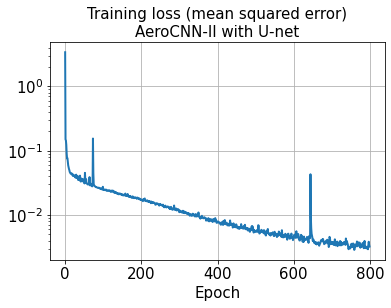

In [30]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II with U-net', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

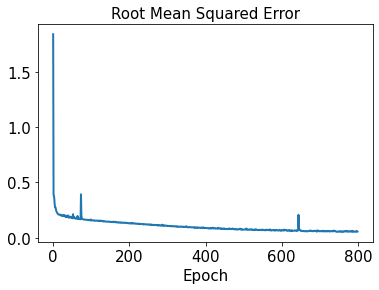

In [31]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

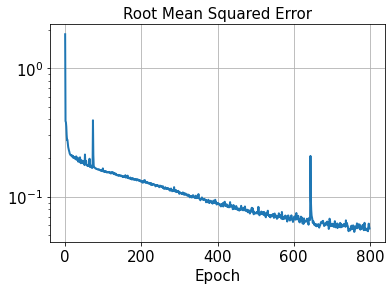

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [33]:
with mirrored_strategy.scope():
    test_results = model.evaluate(x_train)
    decoded_train = model.predict(x_train)
    decoded_test = model.predict(x_test)

4/4 [==============================] - 0s 26ms/step


In [34]:
test_results2 = model.evaluate(x_test)

4/4 [==============================] - 0s 6ms/step - loss: 5.9492e-05 - rmse: 0.0000e+00


In [35]:
y_train.shape

(2016, 101, 101)

In [36]:
y_train.shape[0]

2016

In [37]:
type(decoded_train.shape[3])

int

In [38]:
type(decoded_train)

numpy.ndarray

In [39]:
type(n_grid)

int

In [40]:
decoded_train = decoded_train.reshape((int(y_train.shape[0]),int(n_grid),int(n_grid)))
decoded_test = decoded_test.reshape((int(y_test.shape[0]),int(n_grid),int(n_grid)))

In [41]:
decoded_train.shape

(2016, 101, 101)

In [42]:
y_train.shape[0]

2016

In [43]:
error_train_abs = np.abs(decoded_train - y_train)

In [44]:
error_test_abs = np.abs(decoded_test - y_test)

In [45]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [46]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [47]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [48]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [49]:
decoded_train.shape

(2016, 101, 101)

In [50]:
os.chdir("D:\\TrainedModels")

In [51]:
os.chdir("D:\\TrainedModels\\20221010")
model.save('AeroCNN-II_with_U-net_FlowFieldPrediction_50kernel_2by2MaxPooling_2CNNlayer_testSize0.05.h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [52]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.01197491652968479


In [53]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.03453919283528898


In [54]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.010811809861314126, 0.008376348296054109, 0.007547651619604786, 0.007033789907974446, 0.007743238807472782, 0.0076877808352805626, 0.0071089397422932875, 0.006991368638753761, 0.007215972781438291, 0.007818810357532837, 0.014220899945391191, 0.010407839736637567, 0.012386016392098154, 0.012968656353795426, 0.012967508163102322, 0.01725050999079201, 0.011574486846282555, 0.0077457299298033305, 0.007209887658487265, 0.008479412578071301, 0.008092764035572584, 0.006935308531928707, 0.007851908446983072, 0.0075650283481238315, 0.008994575633464579, 0.007718823243251056, 0.01529110946533927, 0.009212497601915228, 0.00916298237222333, 0.03762570388056562, 0.038917528806942464, 0.04587416005607235, 0.009745807029218906, 0.008763695598906324, 0.007809012335860756, 0.007832084023461635, 0.007385431045850499, 0.007642521606706631, 0.008029660533548998, 0.009123913167570519, 0.008832530853188766, 0.010300008806709731, 0.009748993373678015, 0.009260389726614509, 0.011420175848114271, 0.01859083

In [55]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.008649210013630266, 0.01002785920089901, 0.013887258420537703, 0.00976445340625139, 0.008466461535972051, 0.007789984090614209, 0.008317187096884124, 0.008384813687047663, 0.008458548886957509, 0.008650256531348606, 0.0570288096626008, 0.015258112596042412, 0.031692108043887425, 0.02727754356854859, 0.06012893587477954, 0.07347114381061799, 0.018895418271571467, 0.01823867701462085, 0.018551391198118165, 0.018586625421800358, 0.02056055333406952, 0.018393775120393047, 0.01927243784446361, 0.018714864225725228, 0.019869364315339973, 0.01857631231280516, 0.01804788096063184, 0.020052763509187454, 0.019244356790579162, 0.024015140099518714, 0.060897551630668845, 0.09186953217944821, 0.010102254957757314, 0.01294780182592066, 0.009795215136812765, 0.01034864614581838, 0.010474033804424137, 0.01043840595222518, 0.010367230005100005, 0.011462116274788691, 0.010938576522014205, 0.012342456135289087, 0.04829225284155424, 0.01634645510951107, 0.06711648005171693, 0.06377554179984997, 0.04316

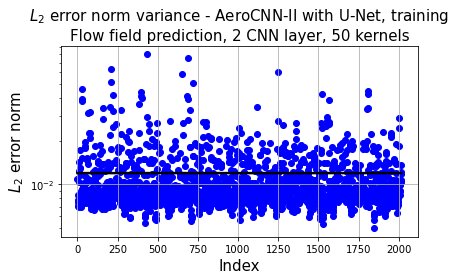

In [71]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II with U-Net, training\nFlow field prediction, 2 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

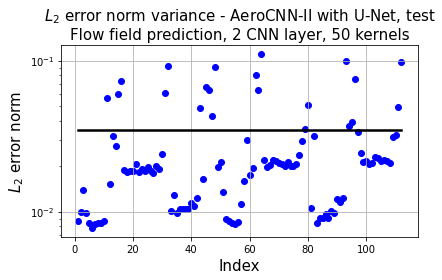

In [72]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II with U-Net, test\nFlow field prediction, 2 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

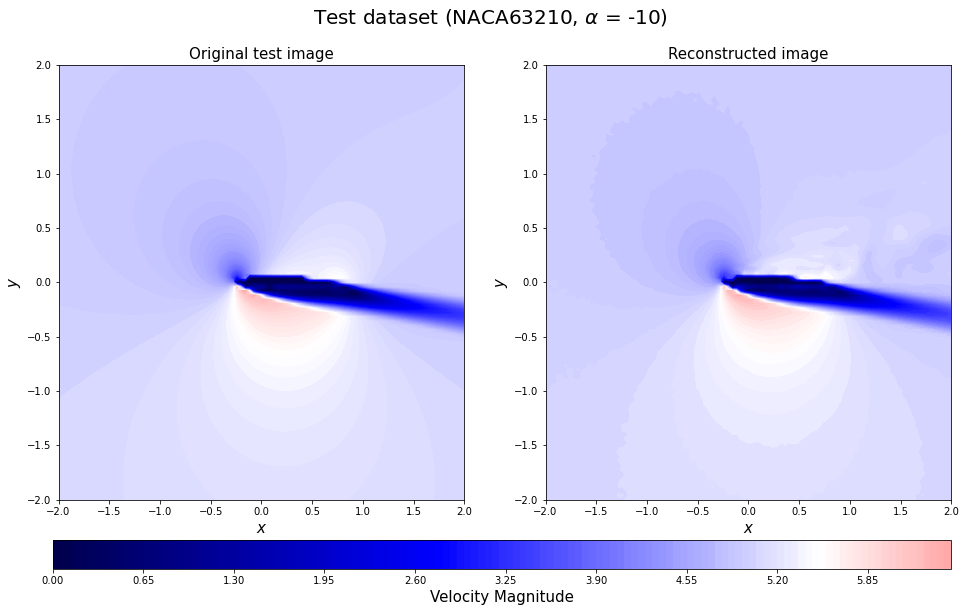

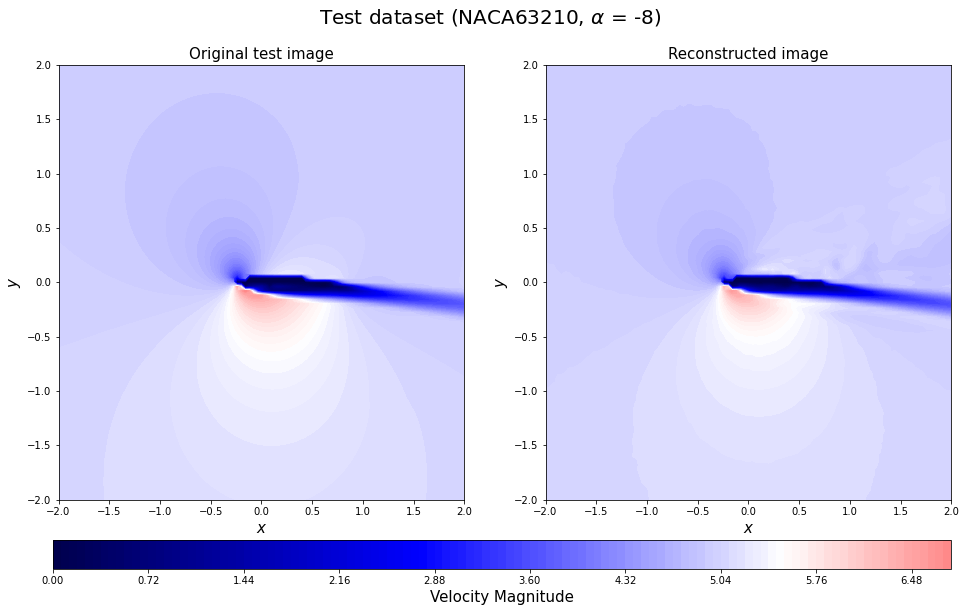

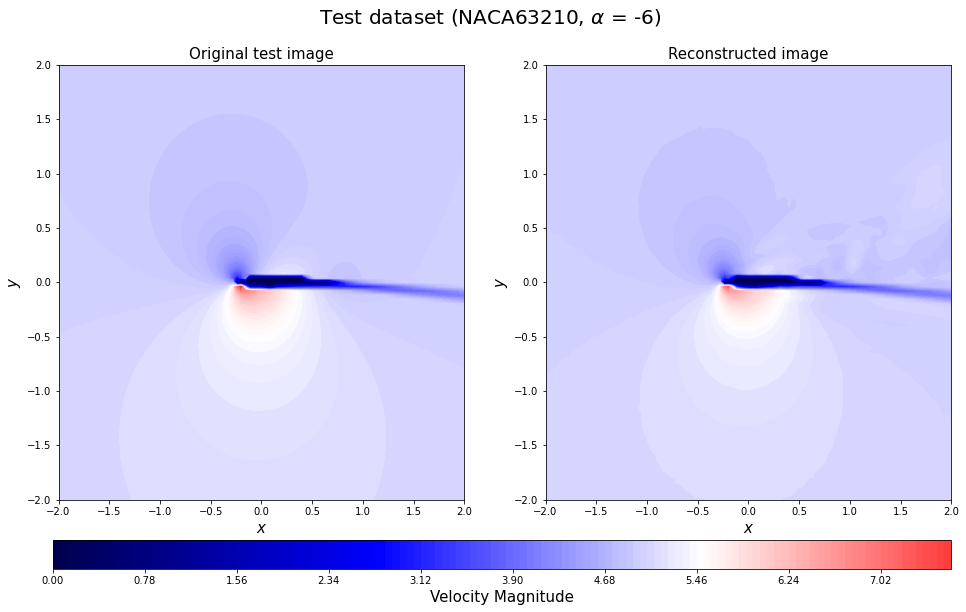

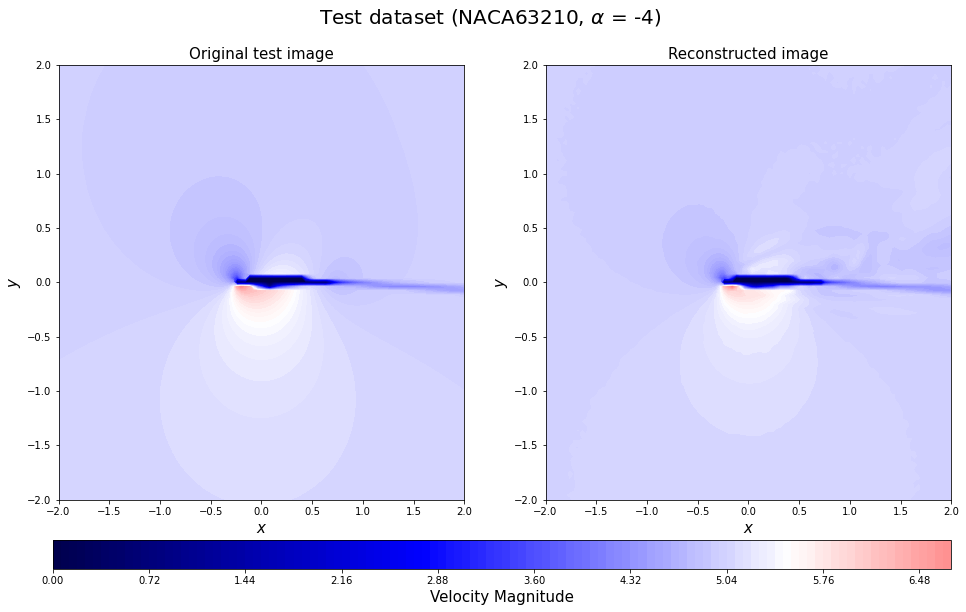

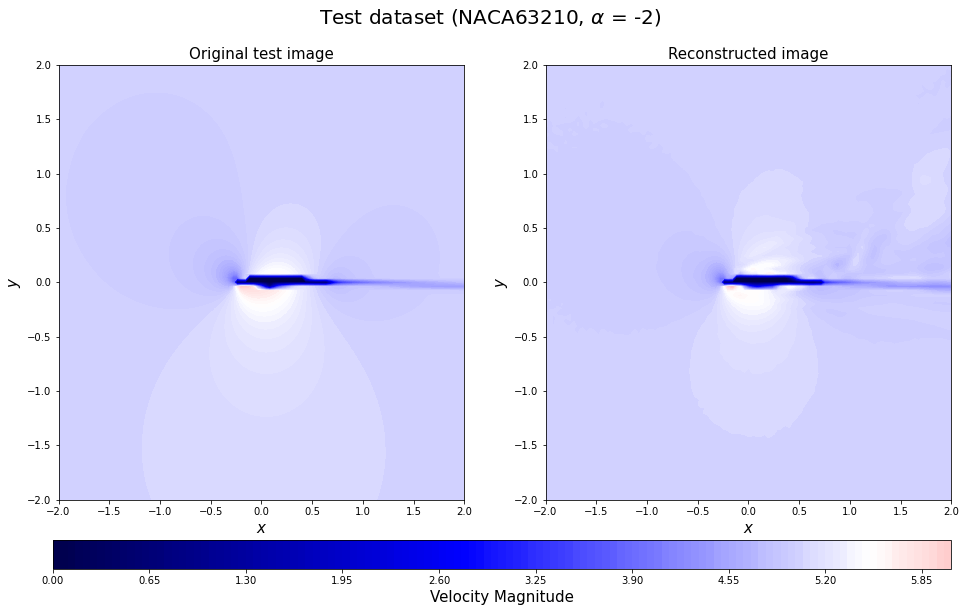

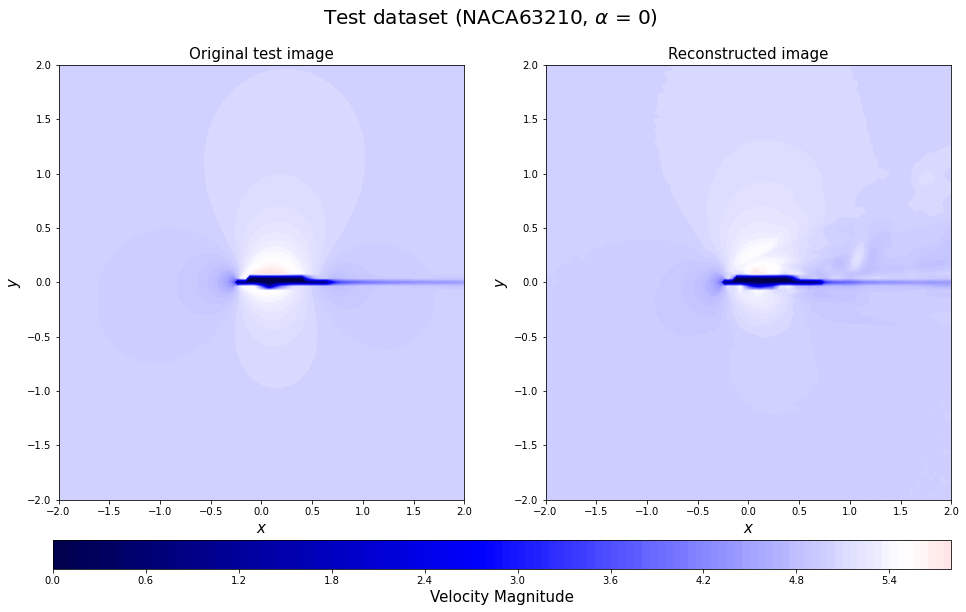

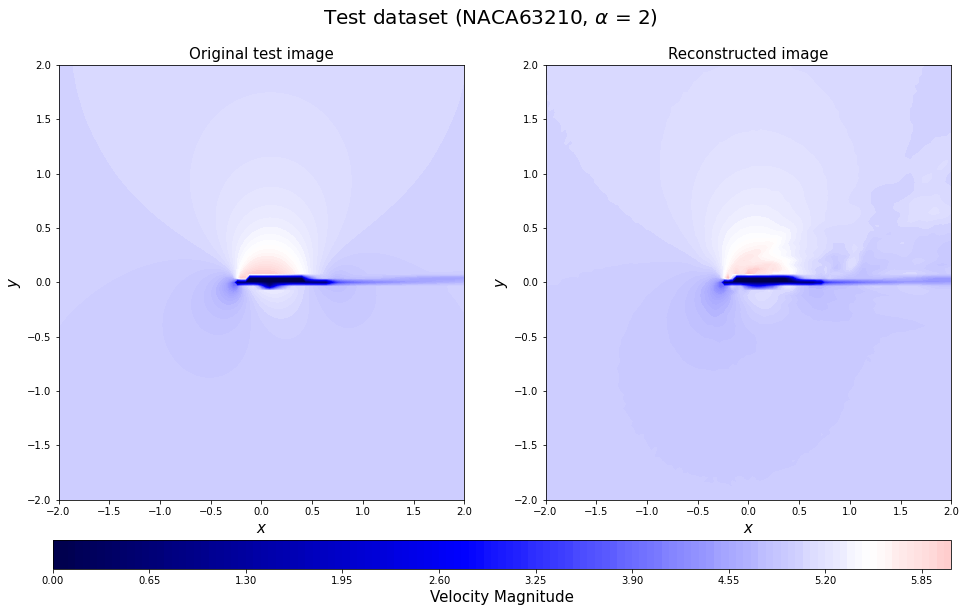

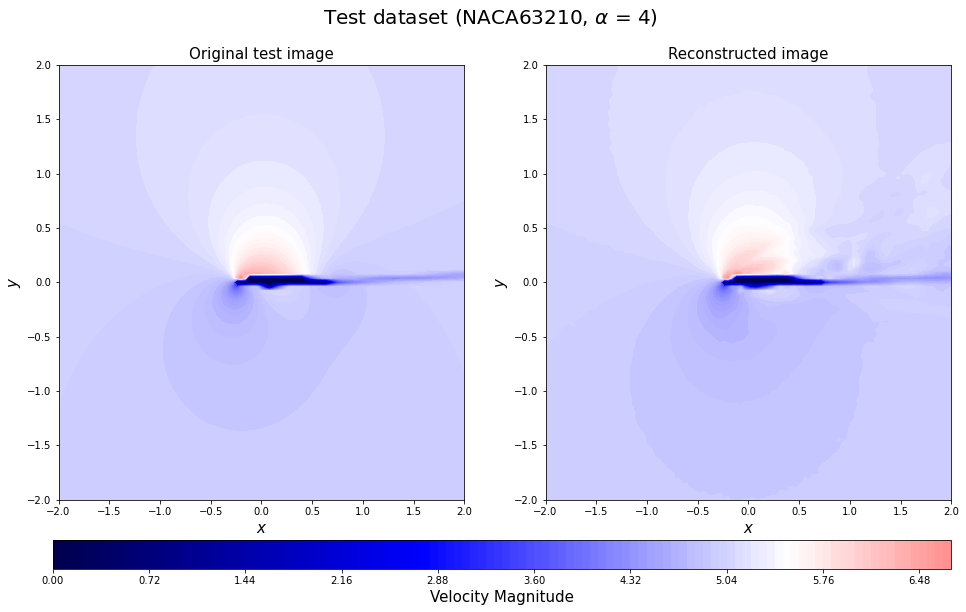

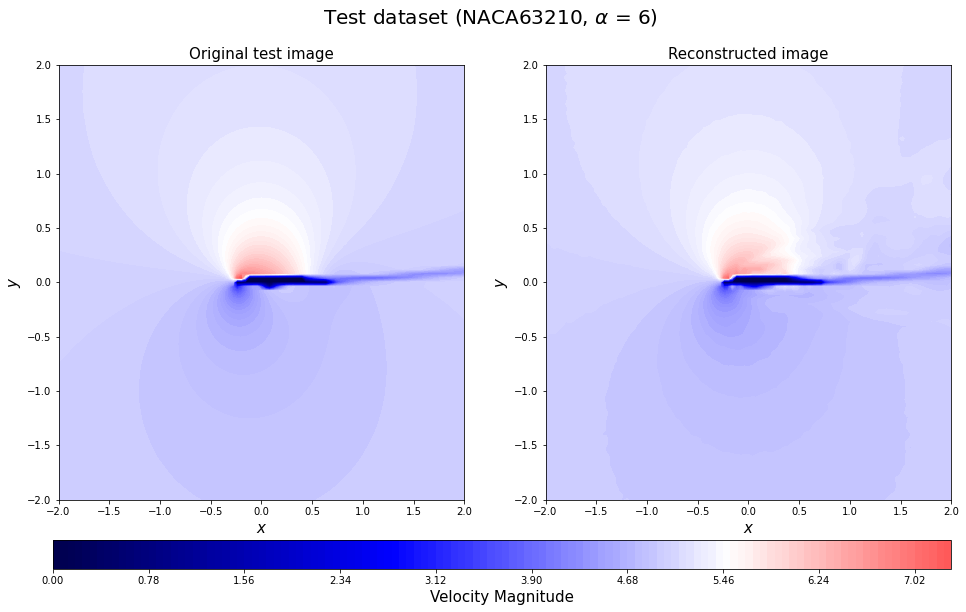

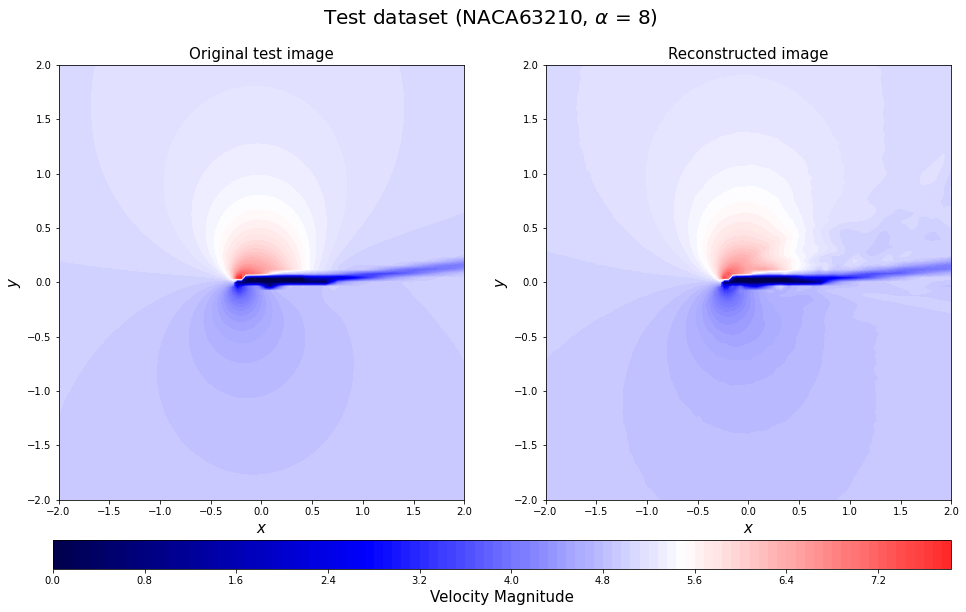

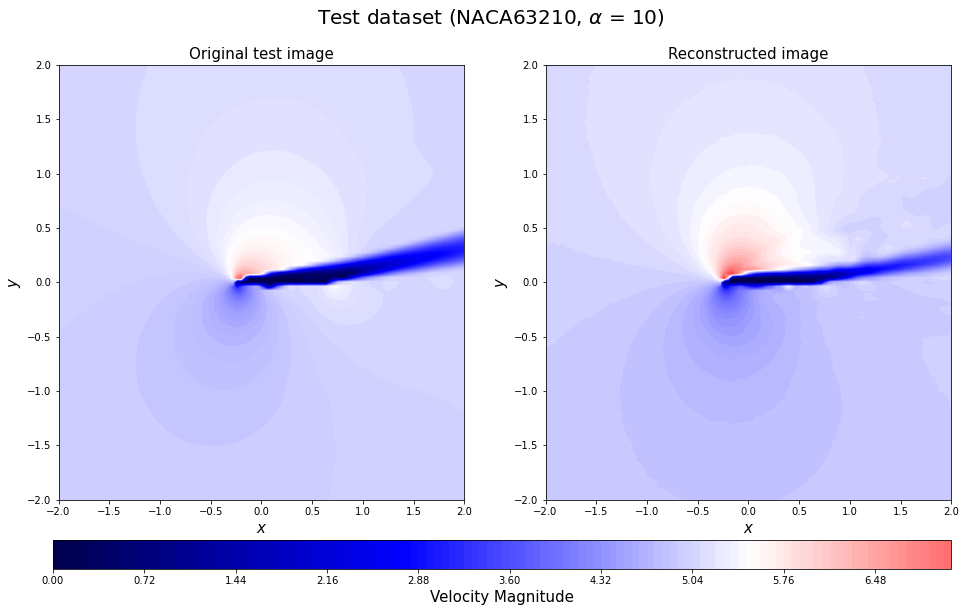

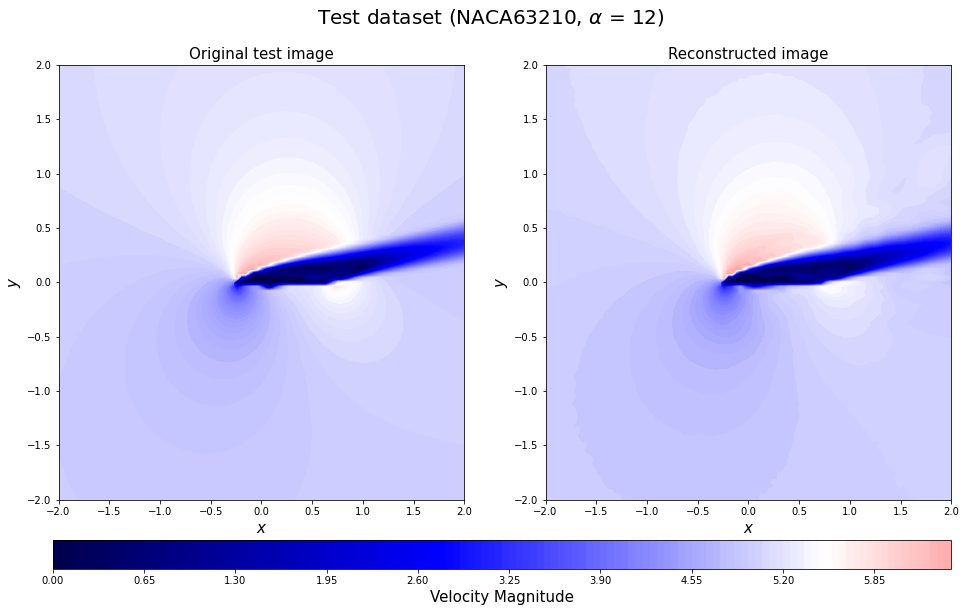

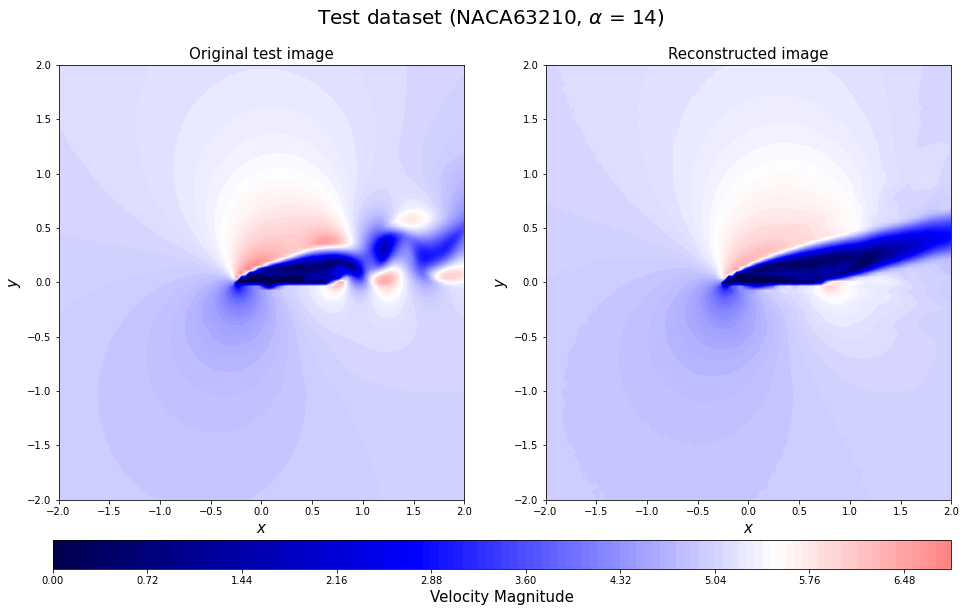

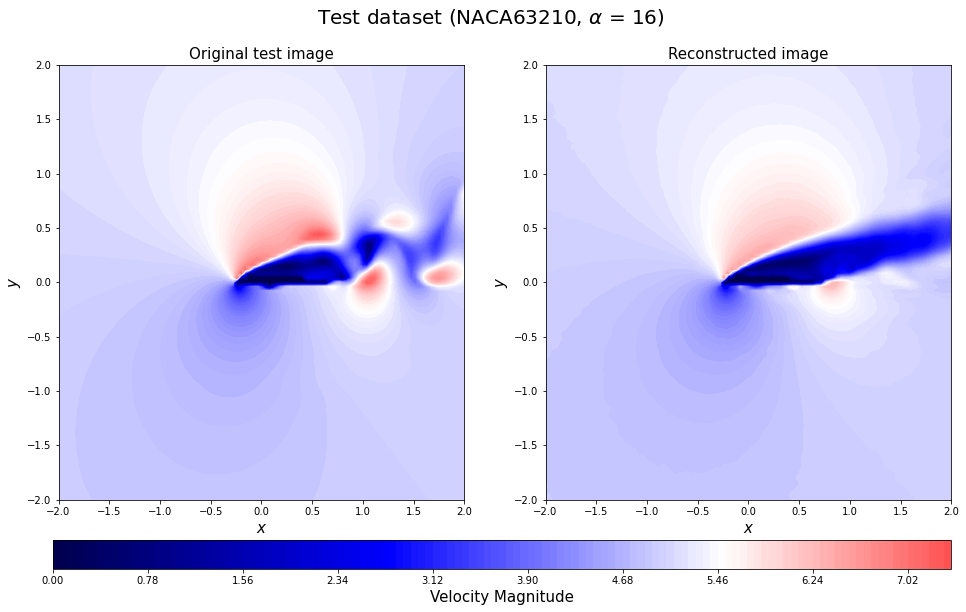

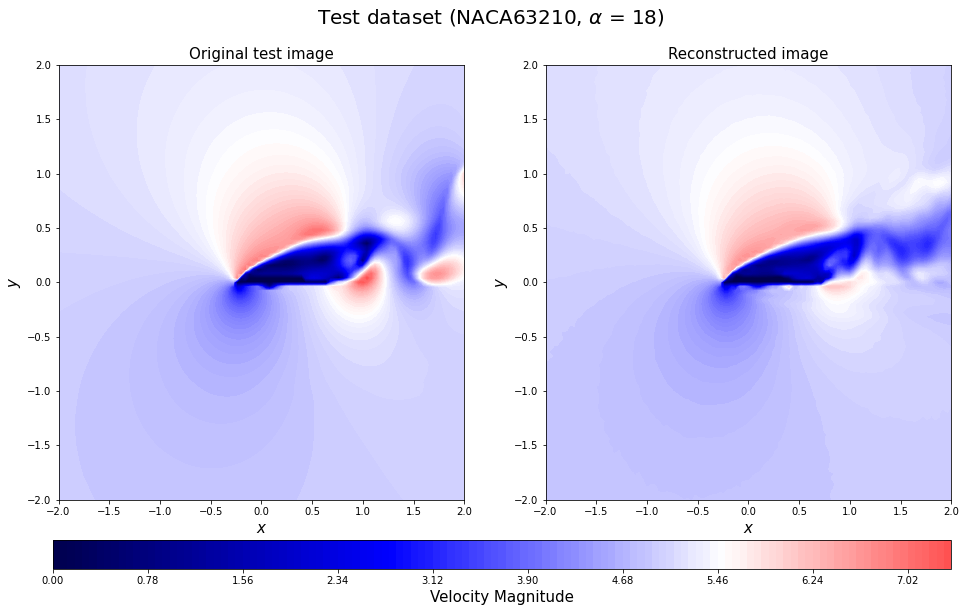

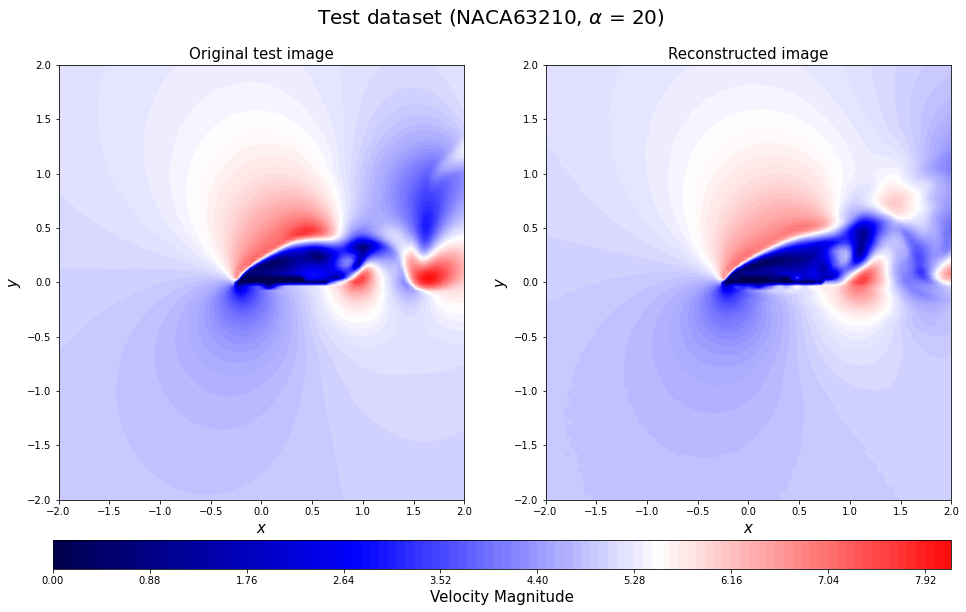

In [58]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_test2_rotate = y_test[2*16+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[2*16+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test2_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[2*16+c])[3:-2], aa_test[2*16+c]),fontsize=20)
    plt.show()

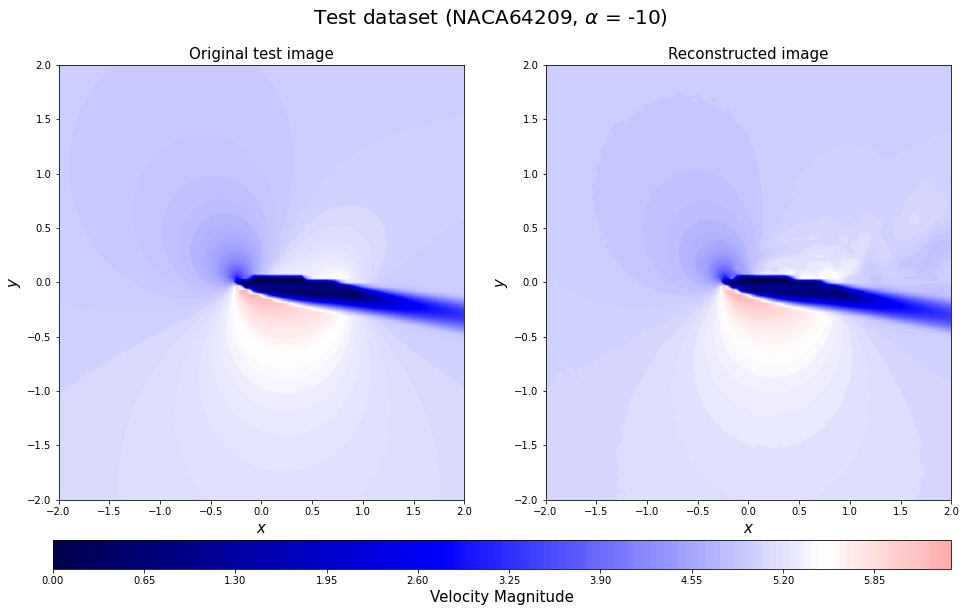

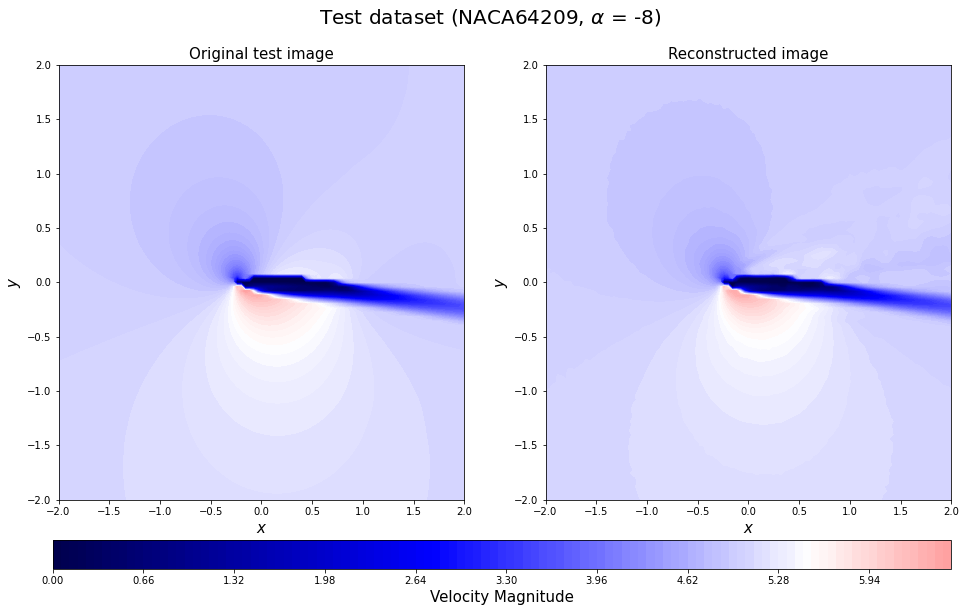

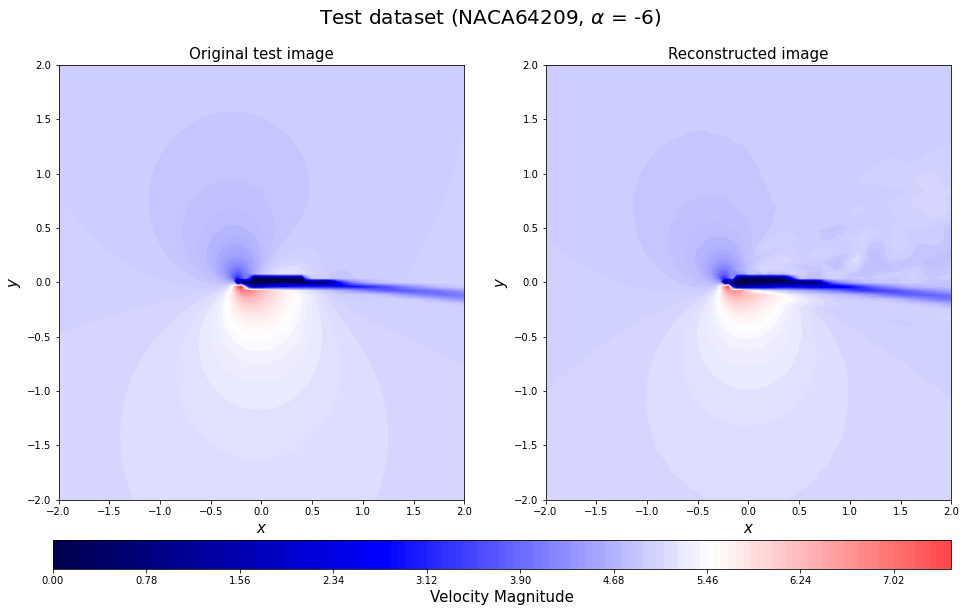

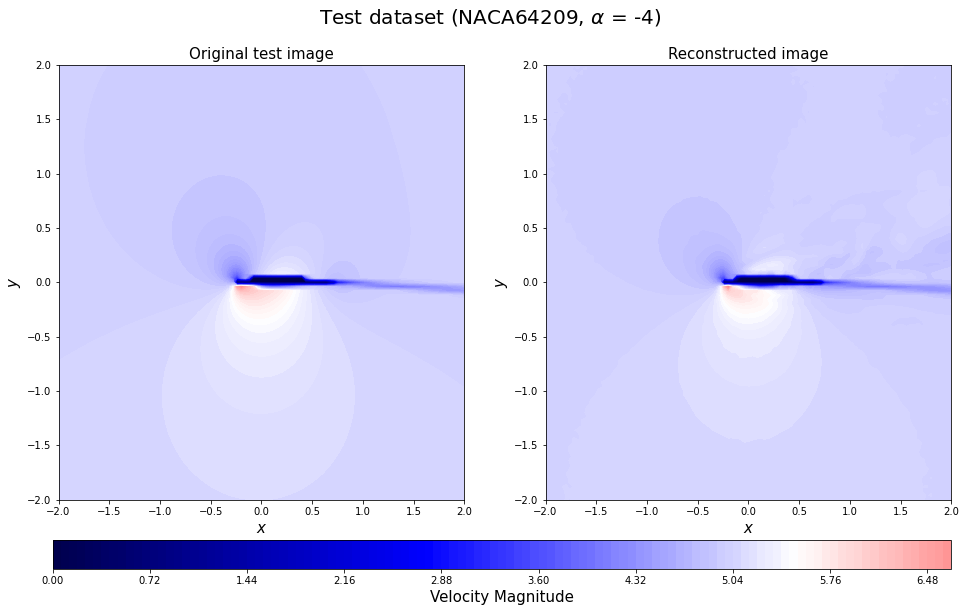

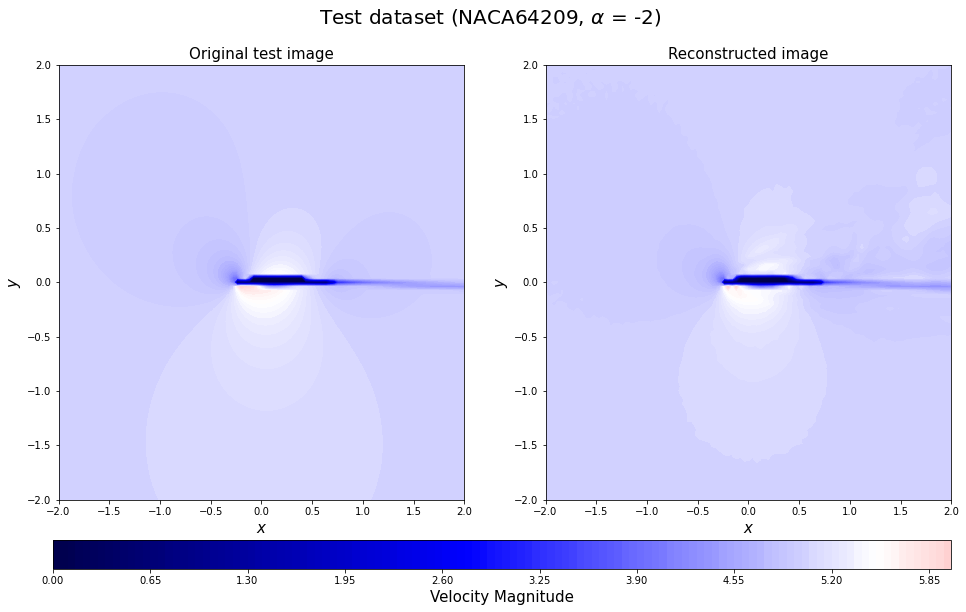

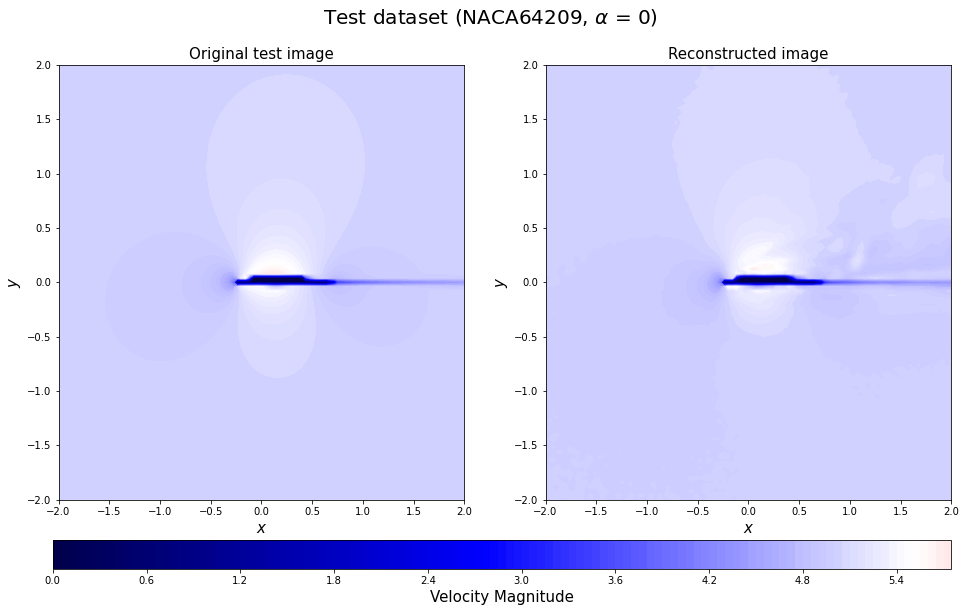

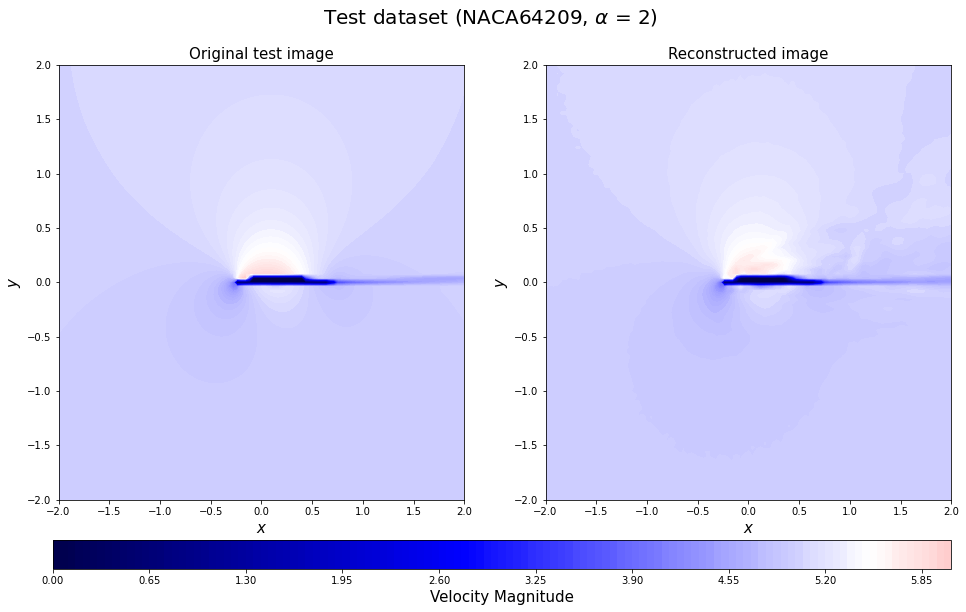

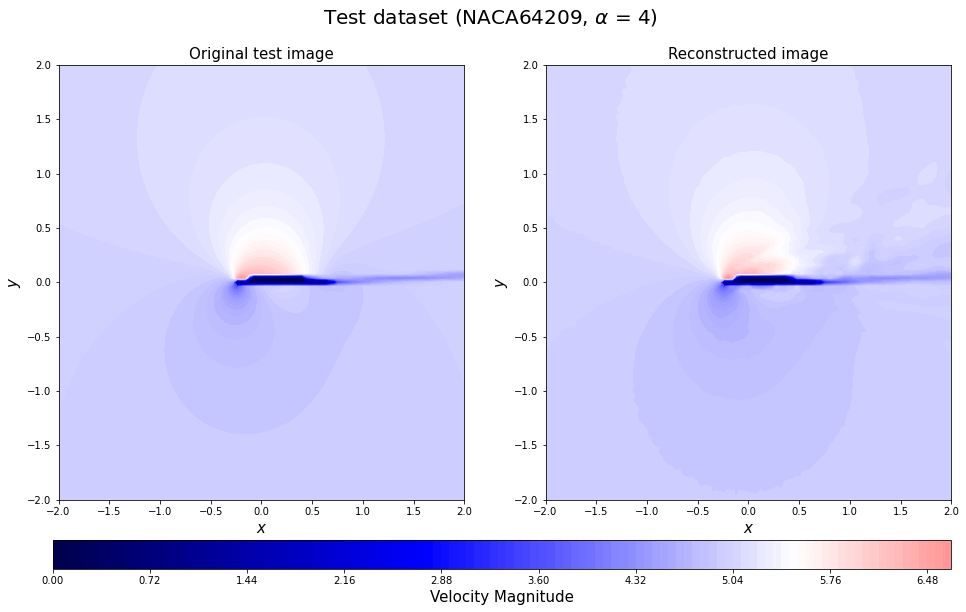

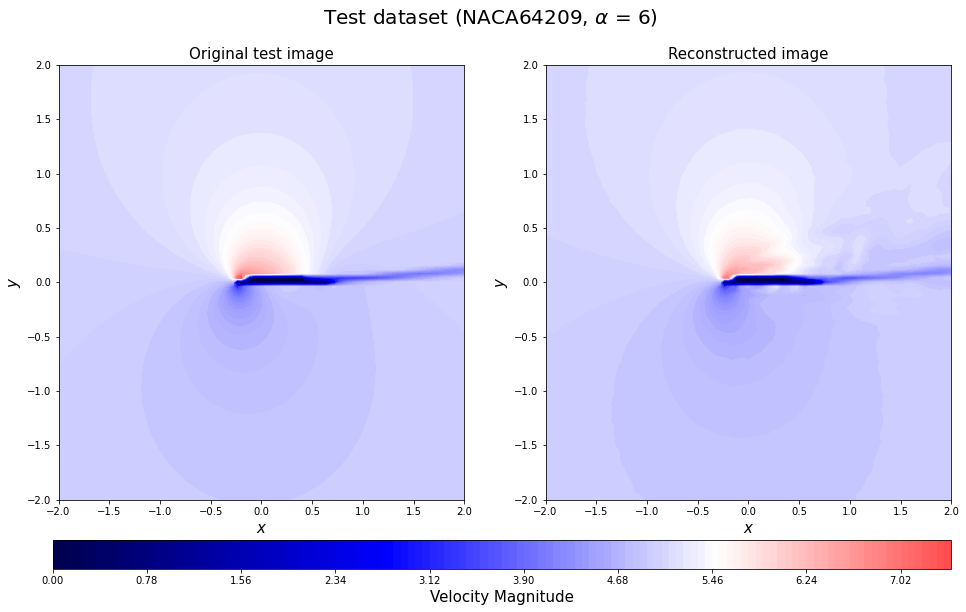

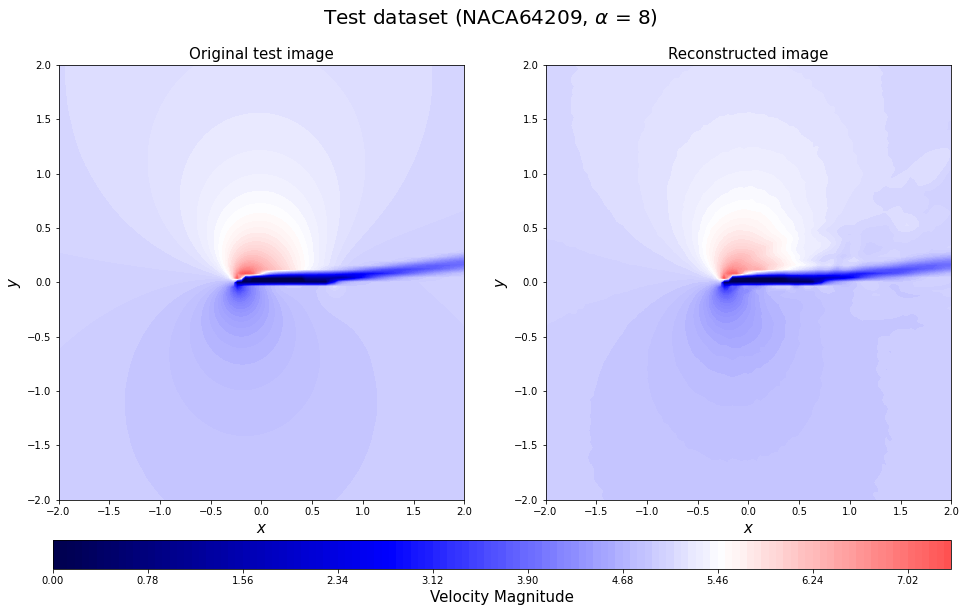

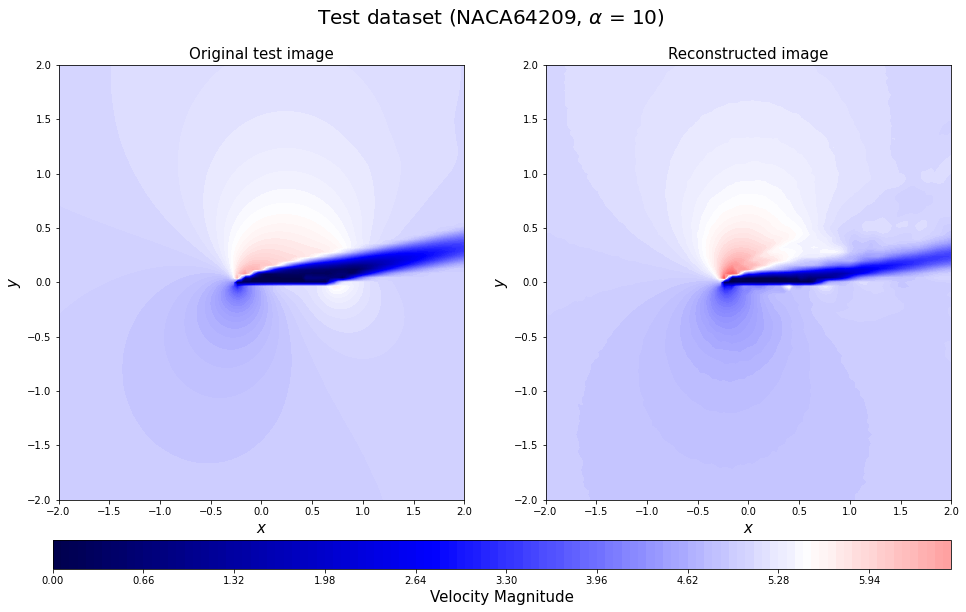

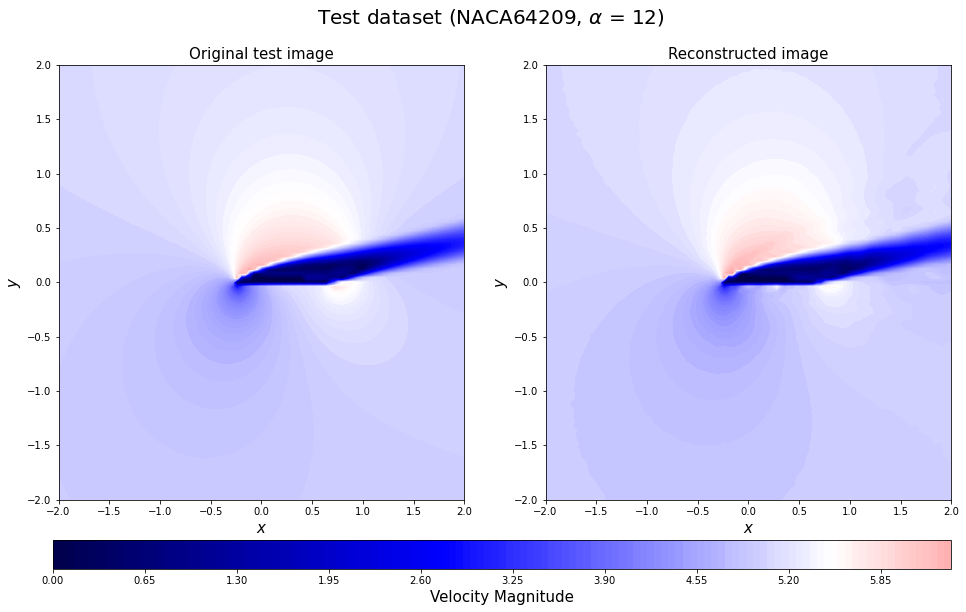

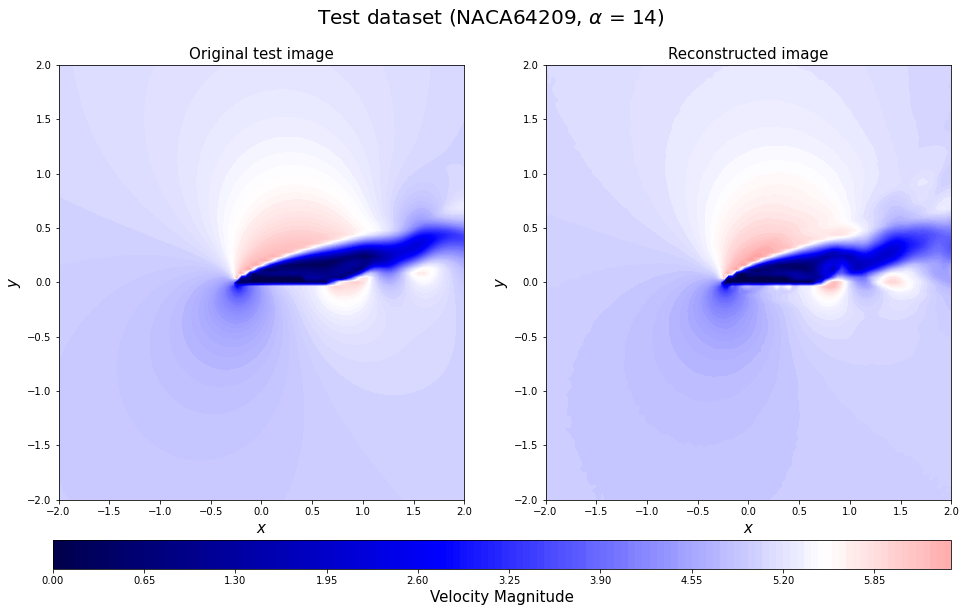

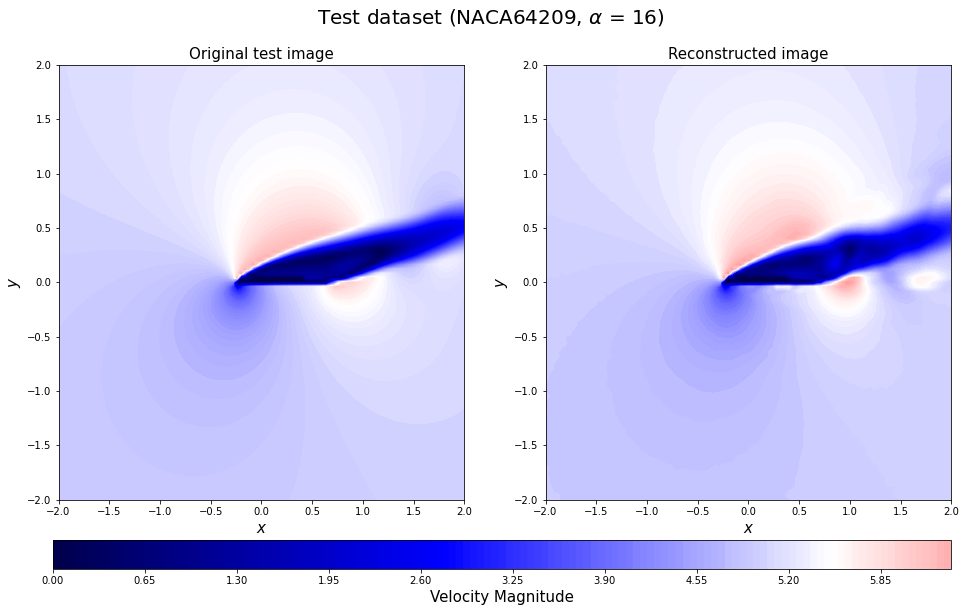

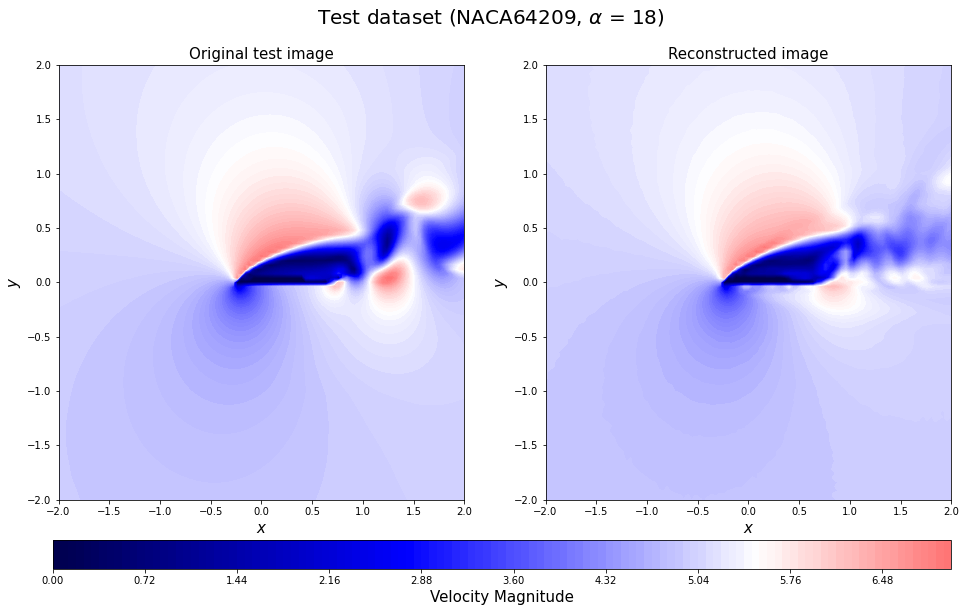

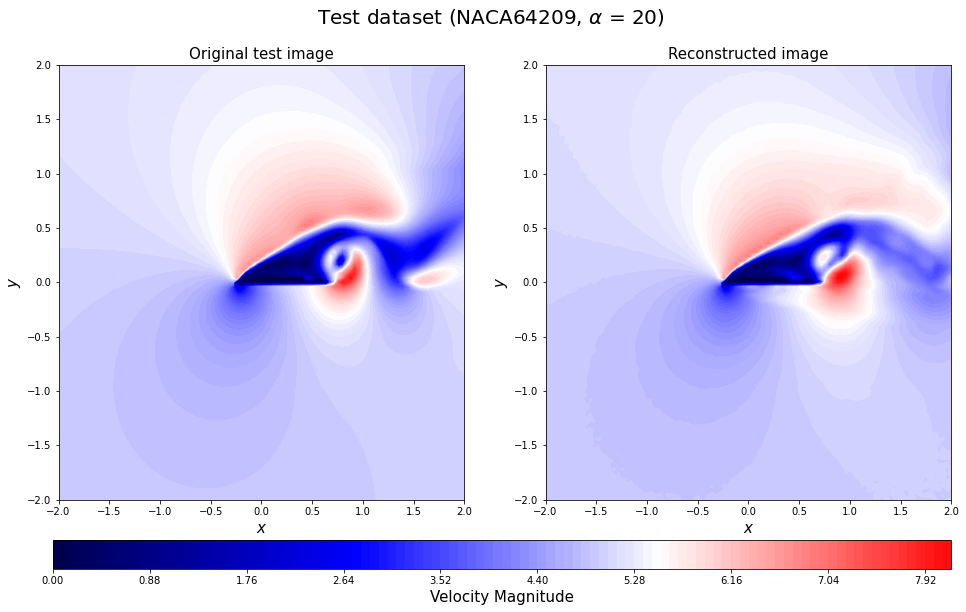

In [59]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_test0_rotate = y_test[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test0_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
    plt.show()

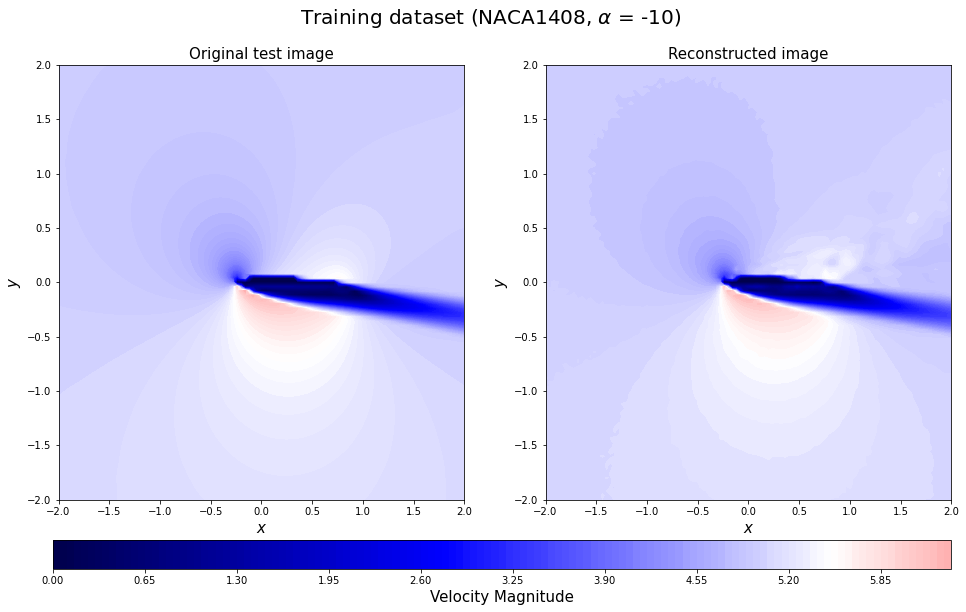

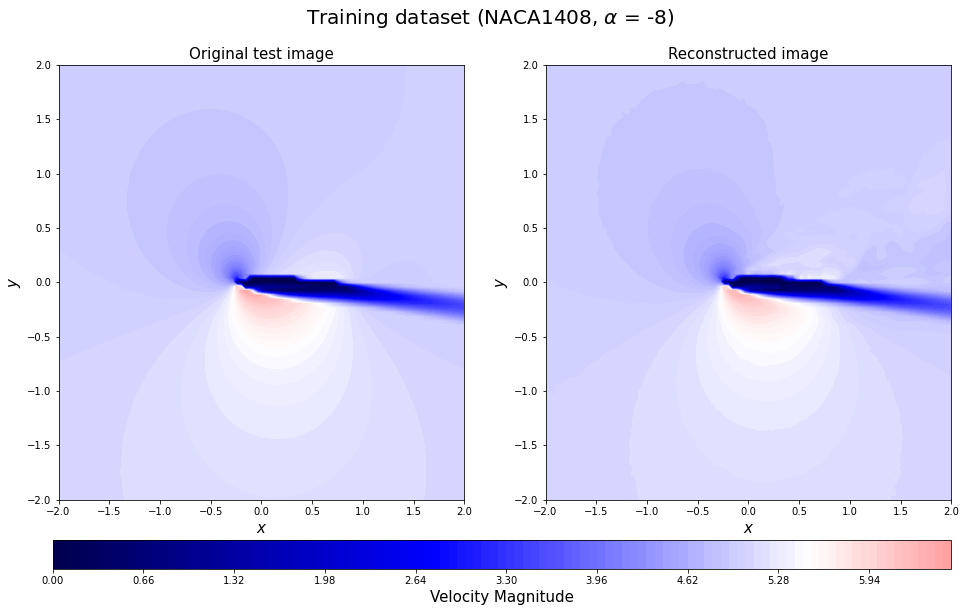

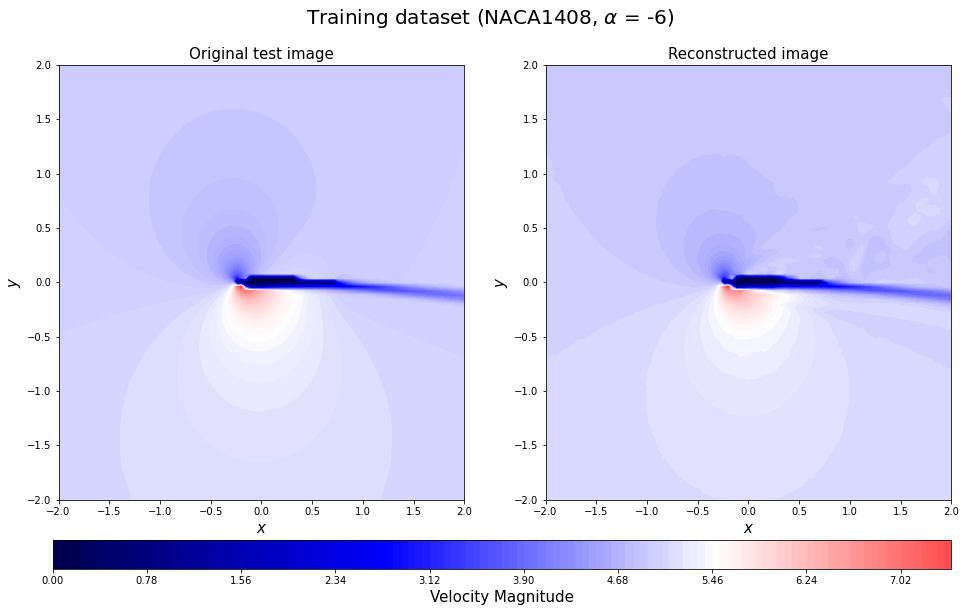

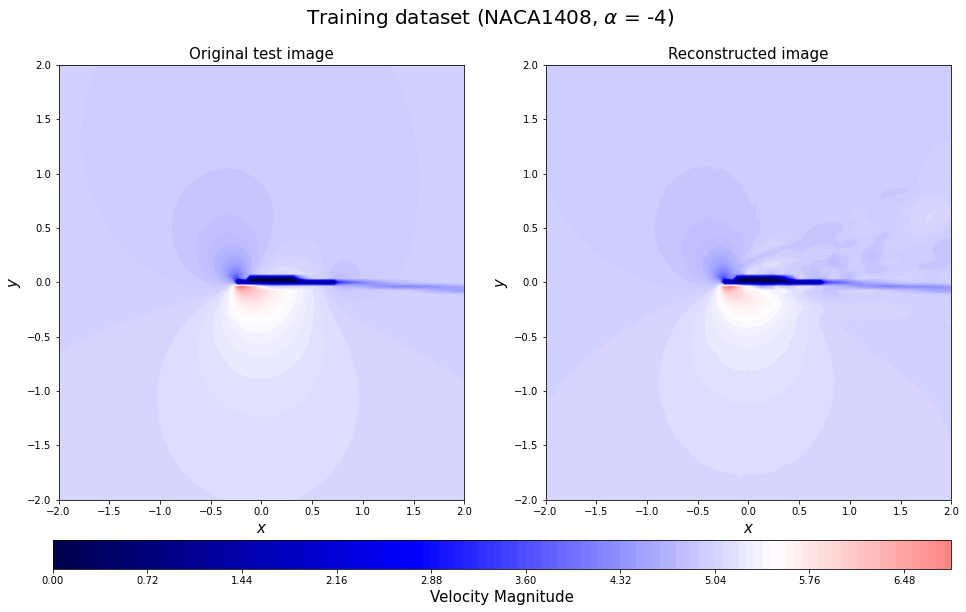

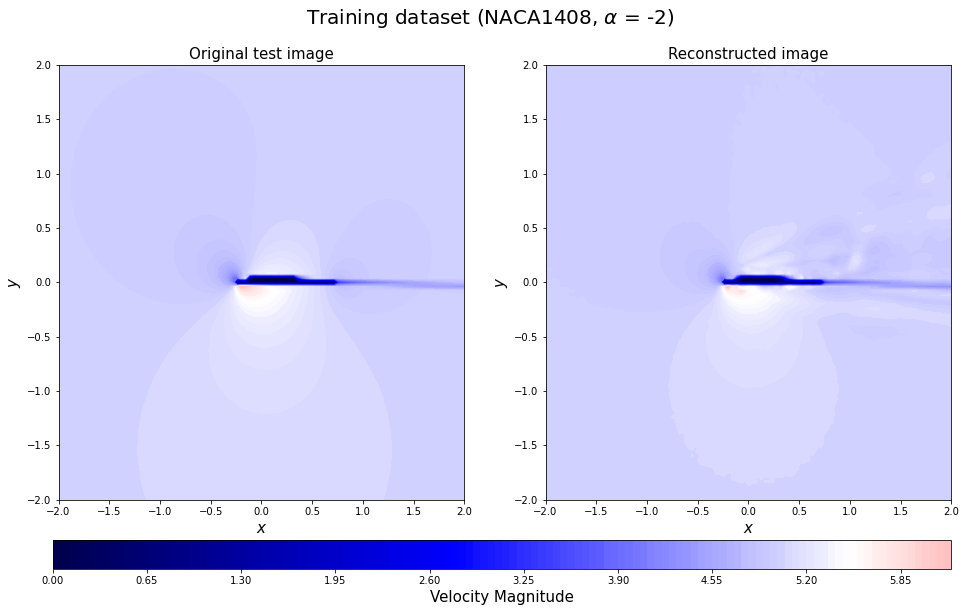

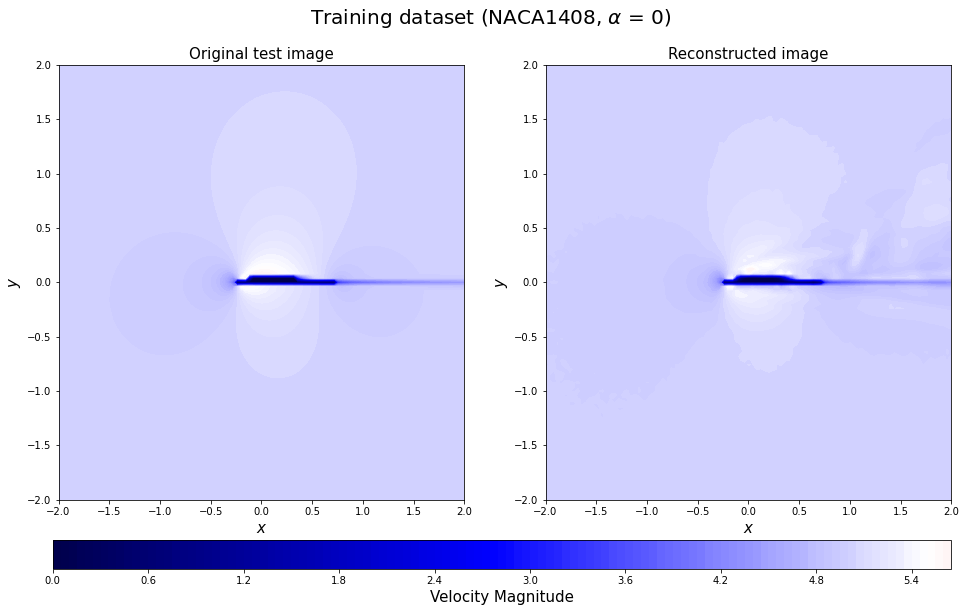

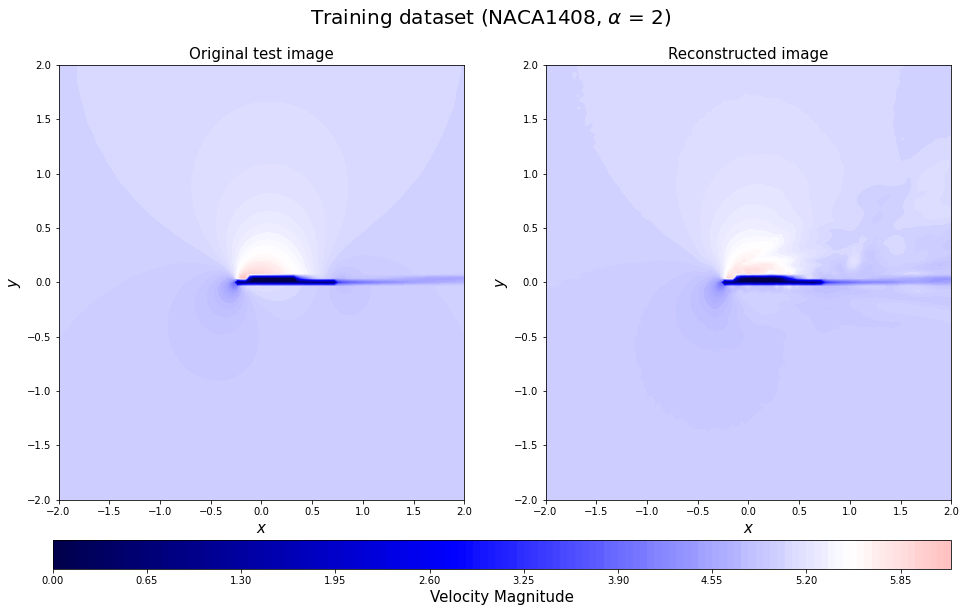

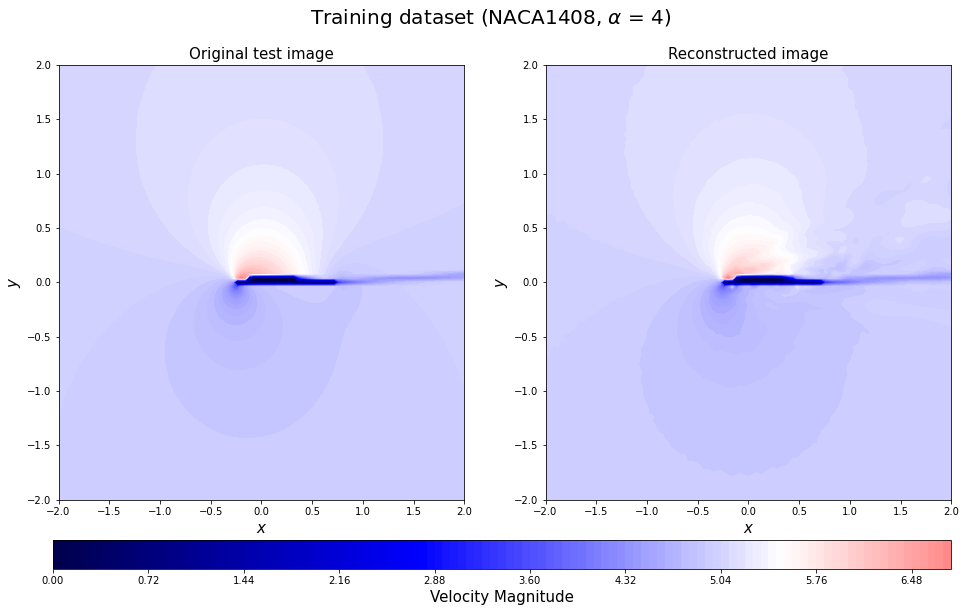

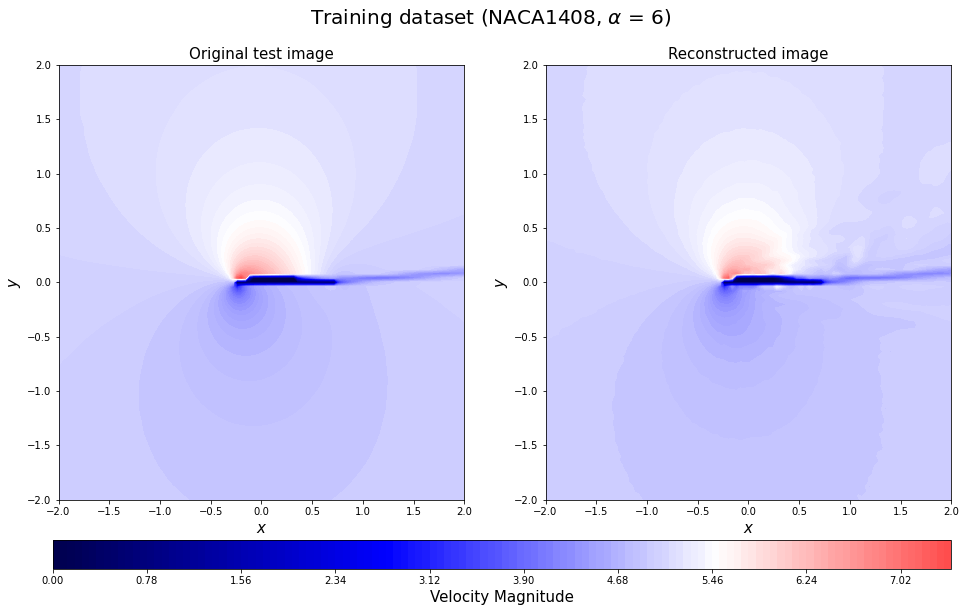

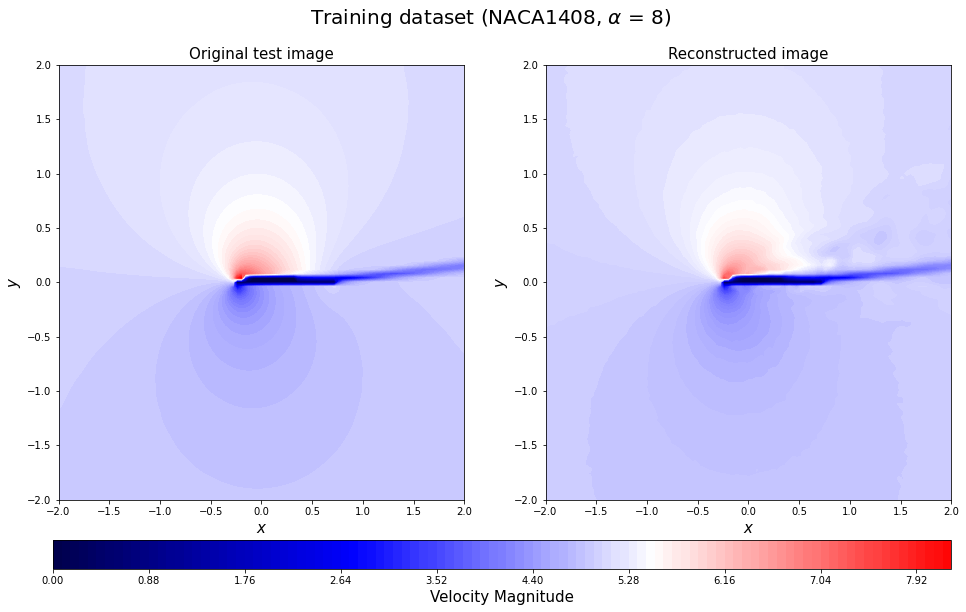

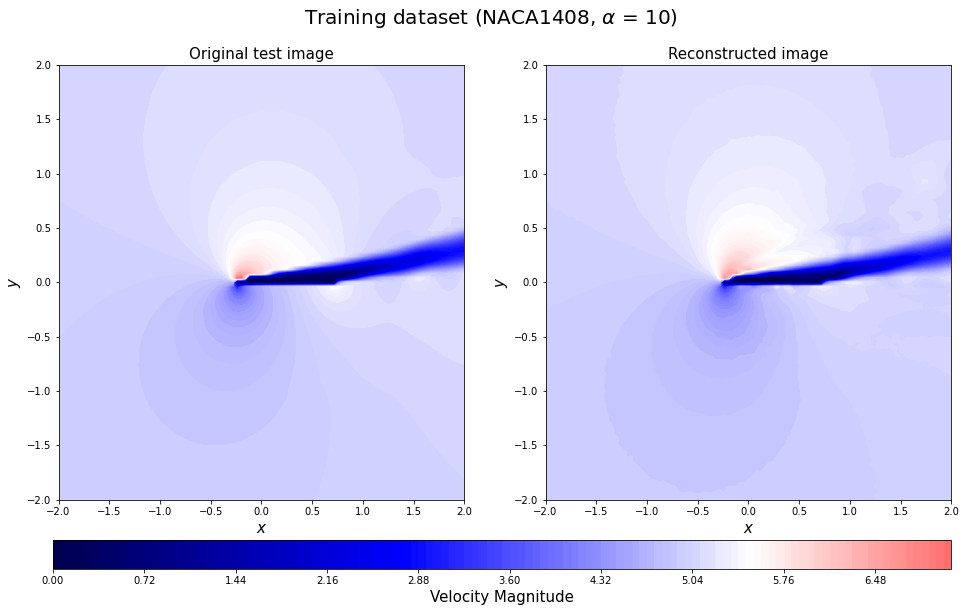

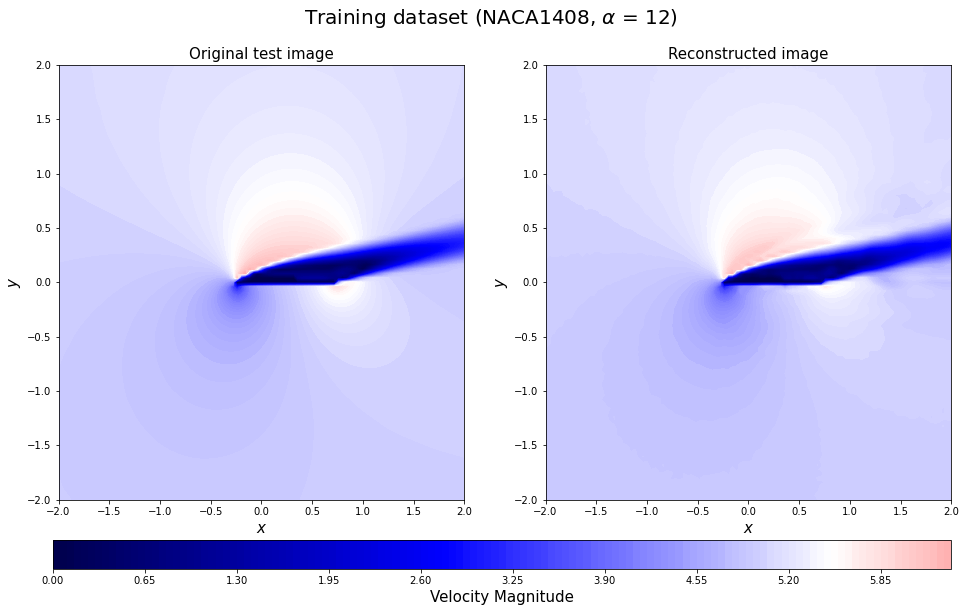

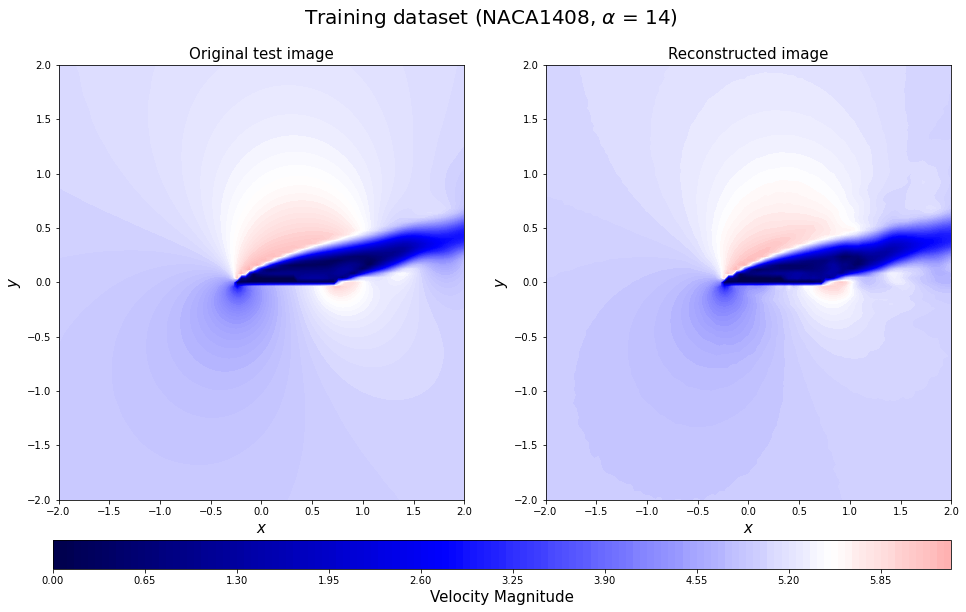

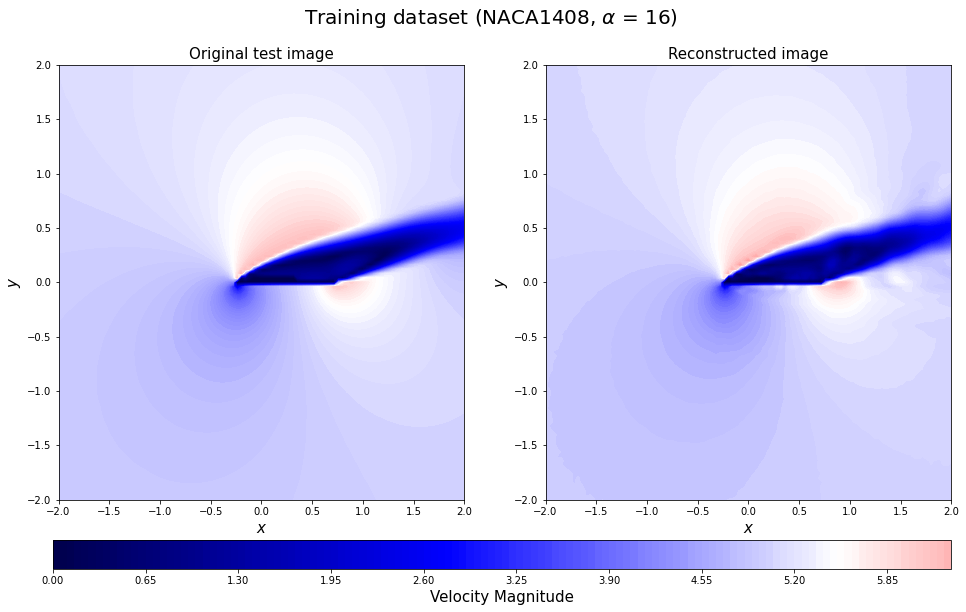

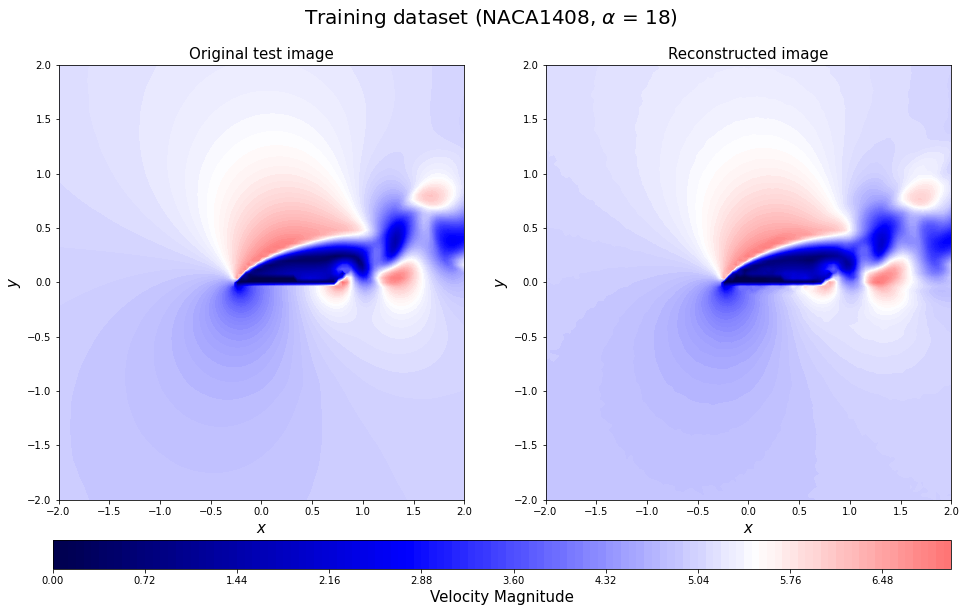

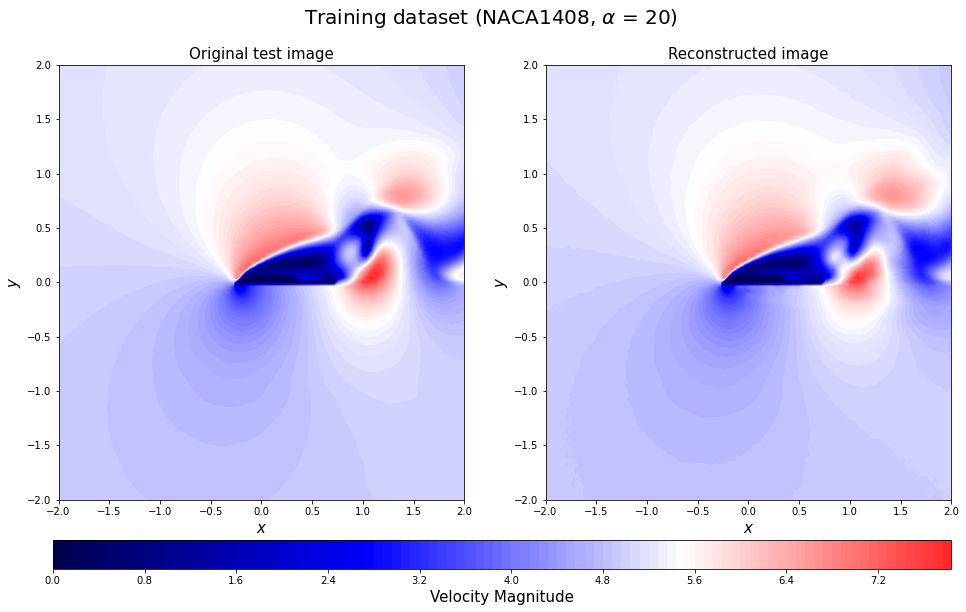

In [60]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_train0_rotate = y_train[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train0_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[c])[3:-2], aa_train[c]),fontsize=20)
    plt.show()

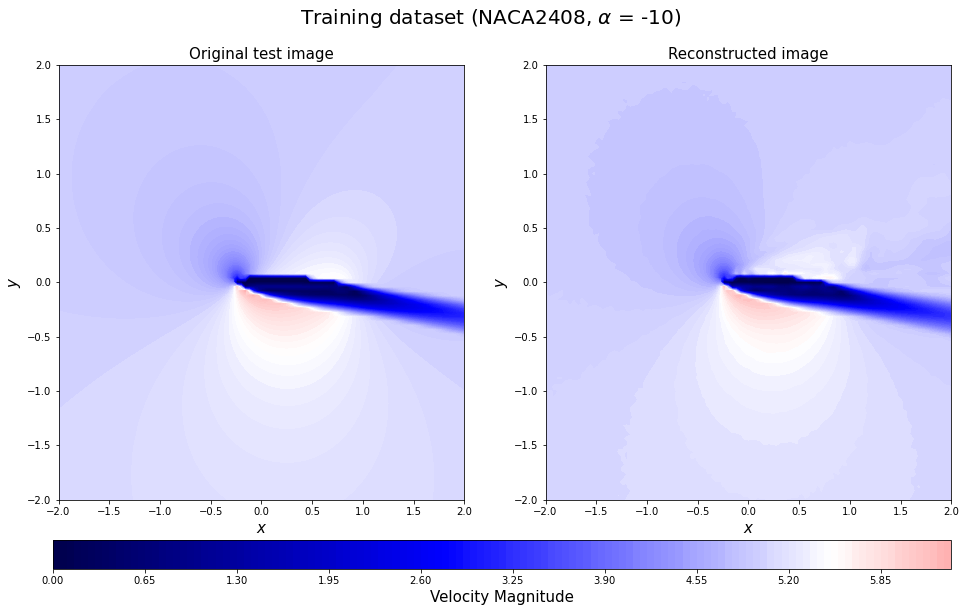

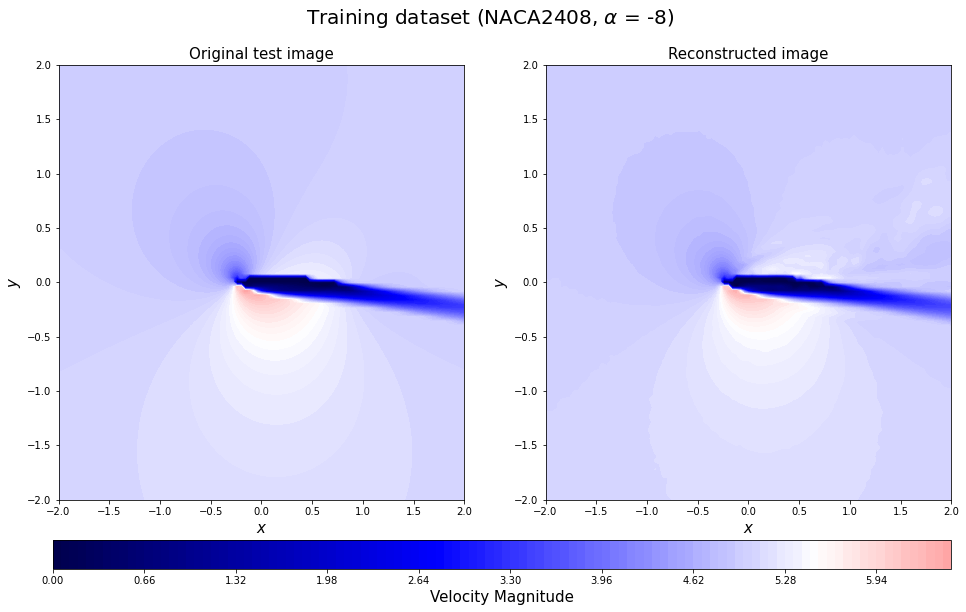

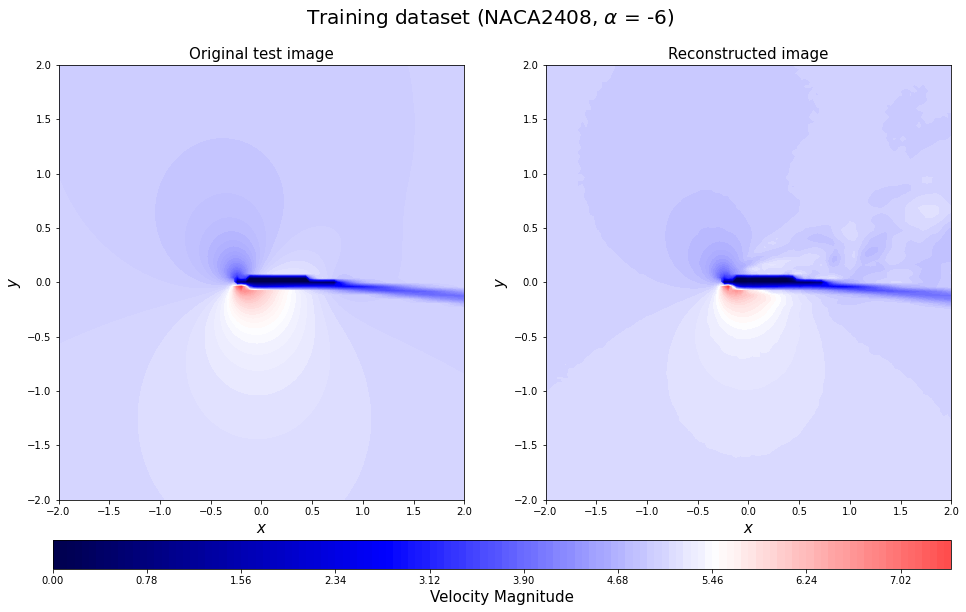

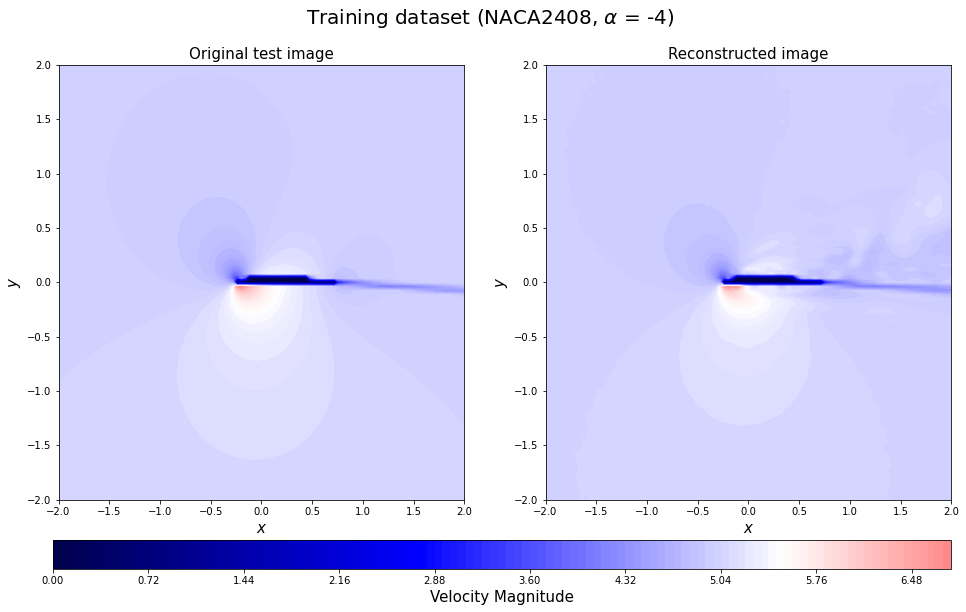

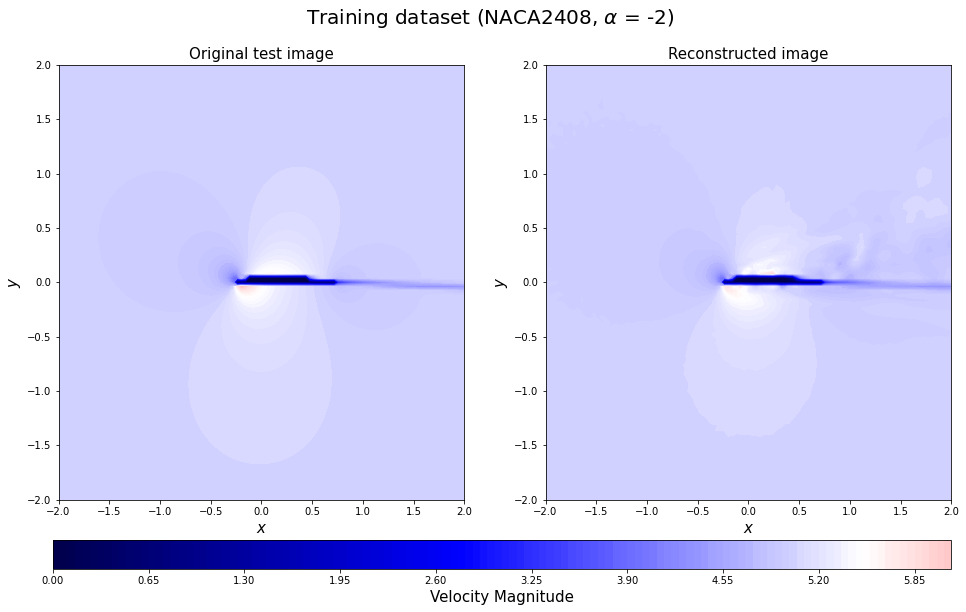

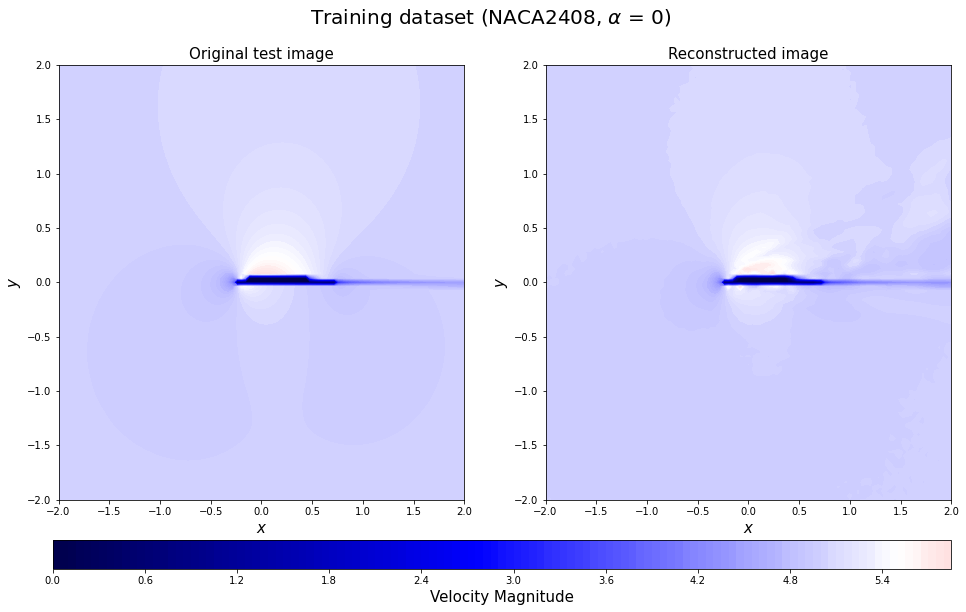

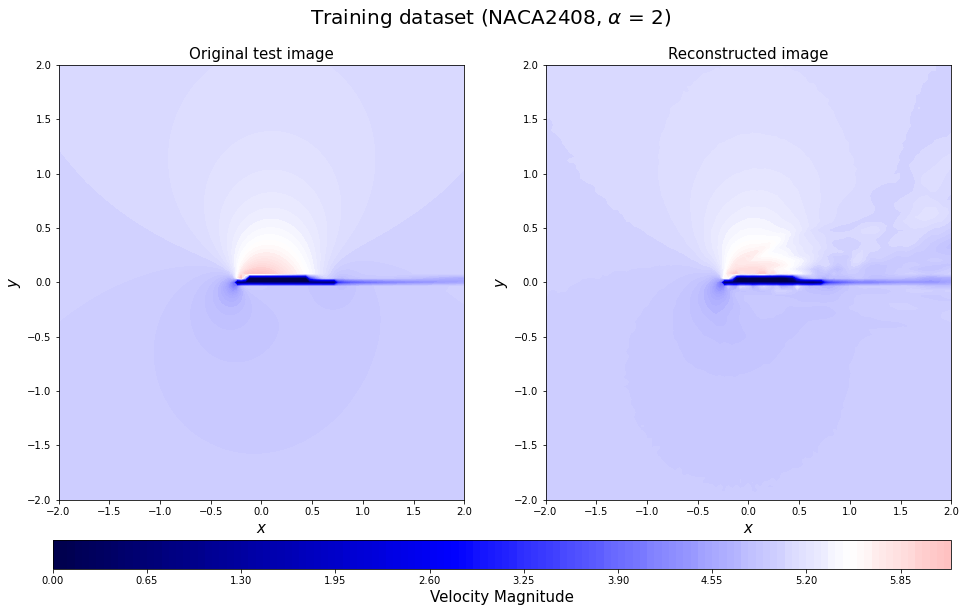

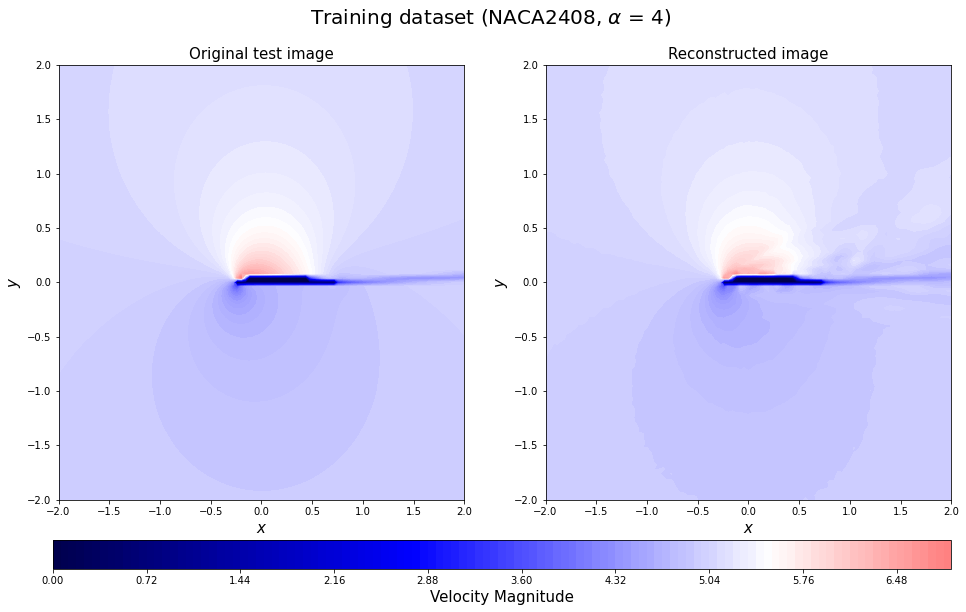

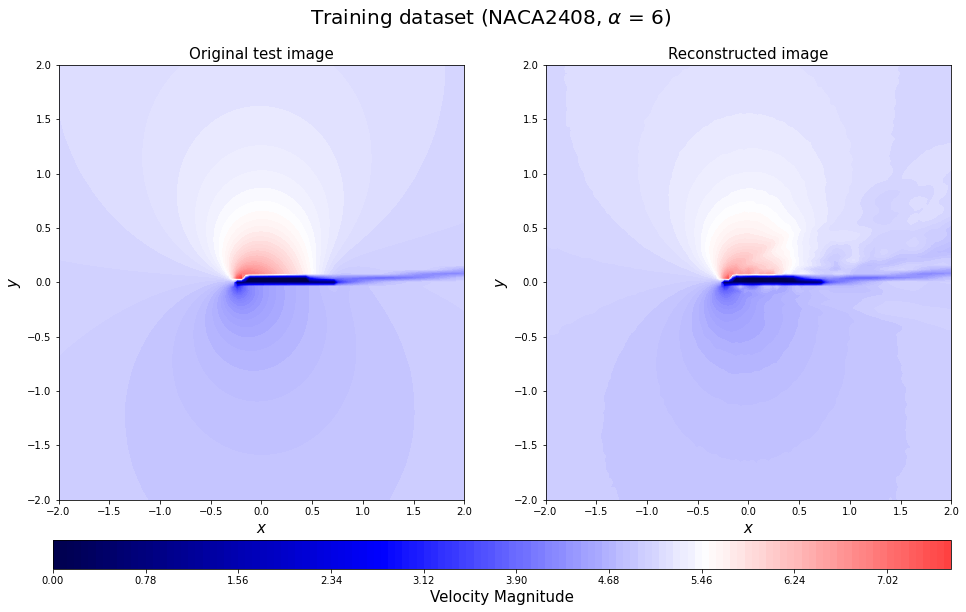

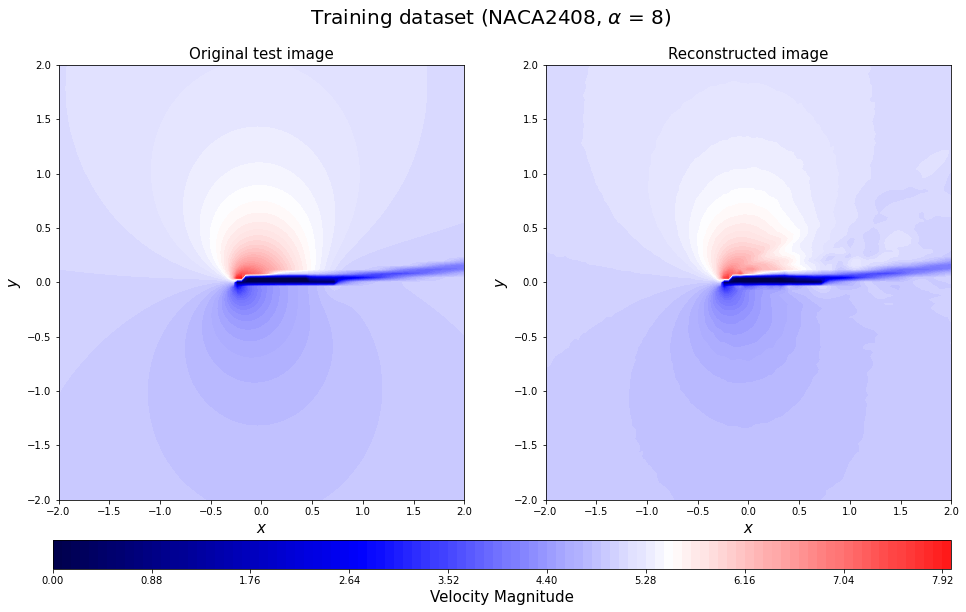

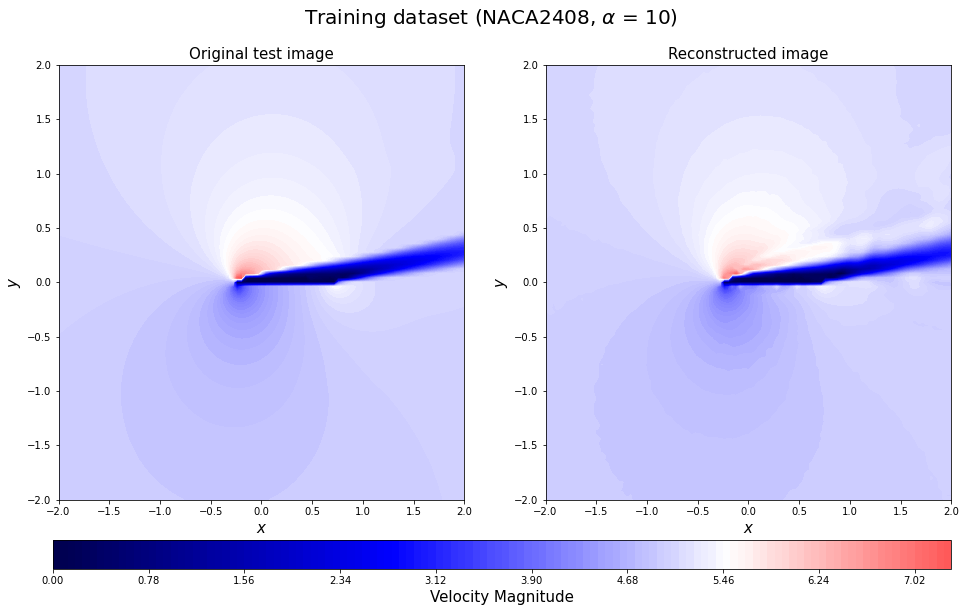

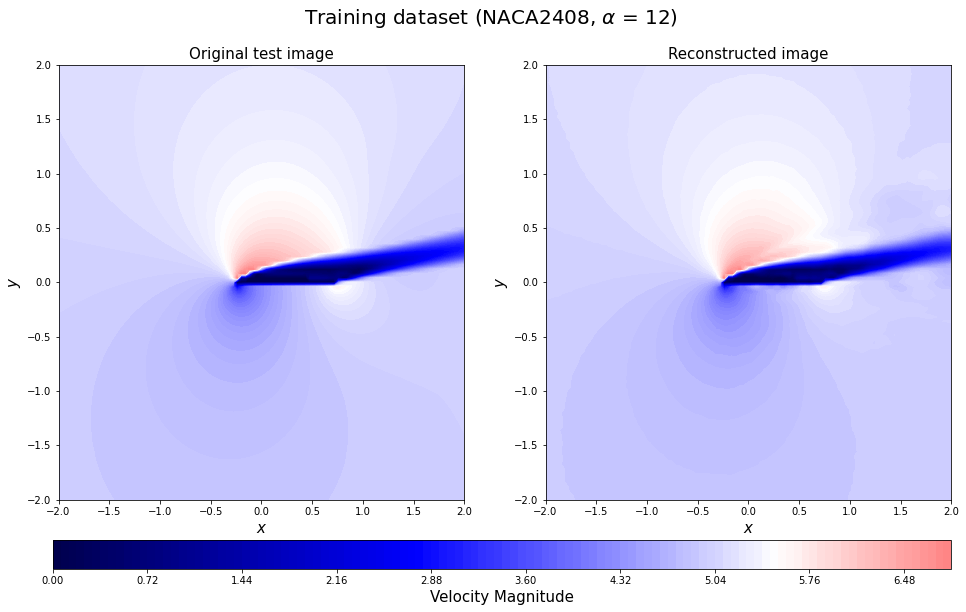

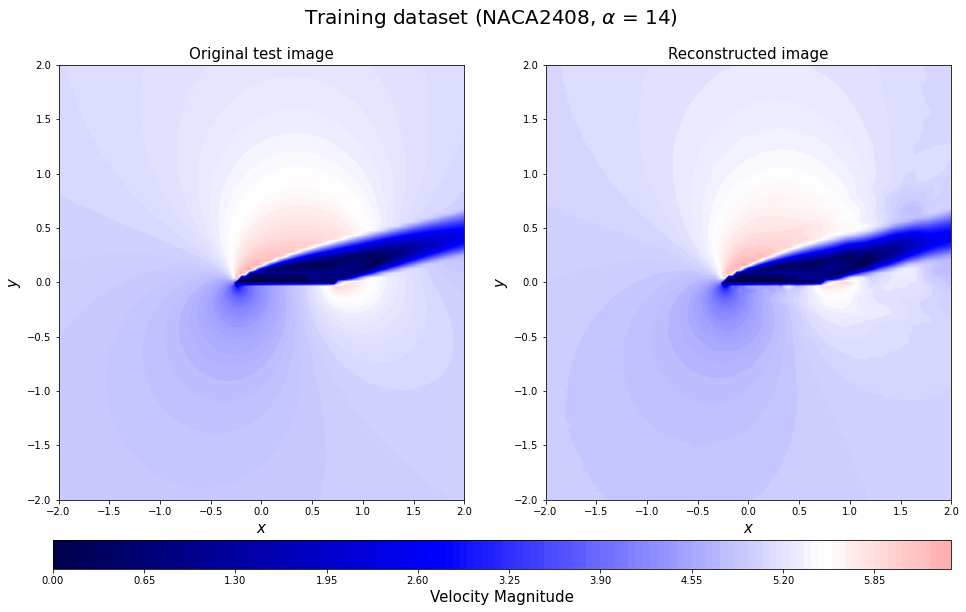

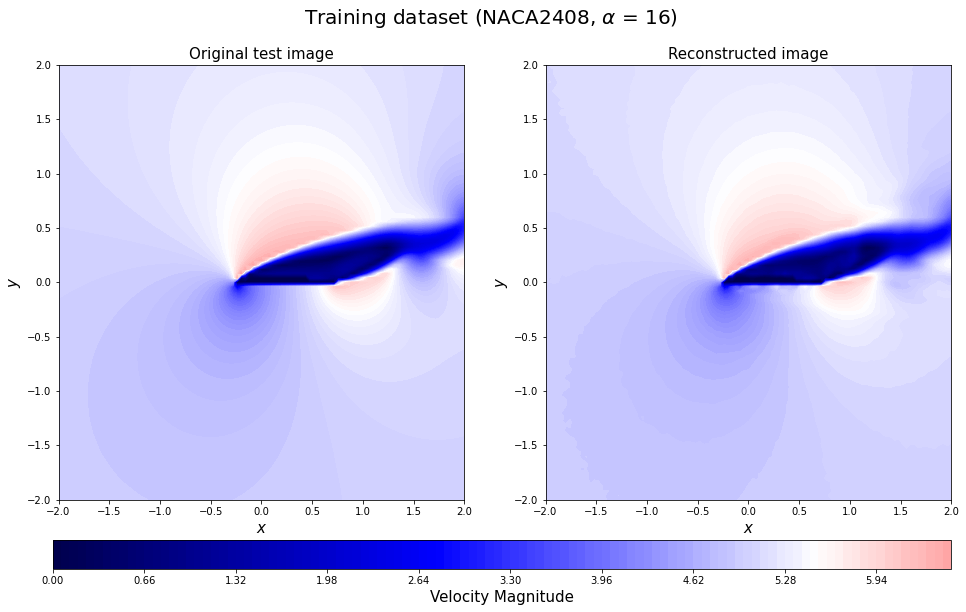

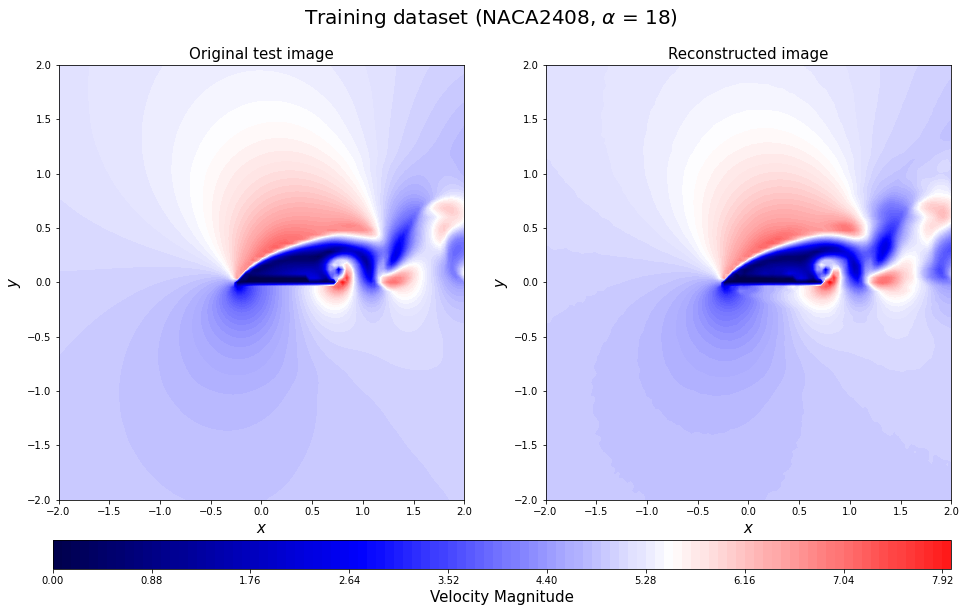

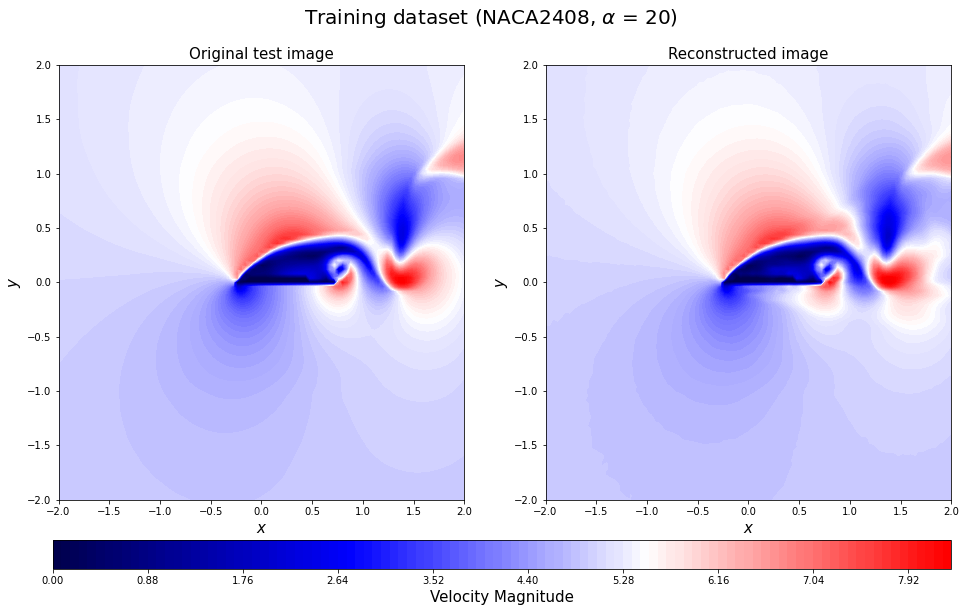

In [61]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_train20_rotate = y_train[20*16+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[20*16+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train20_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[20*16+c])[3:-2], aa_train[20*16+c]),fontsize=20)
    plt.show()

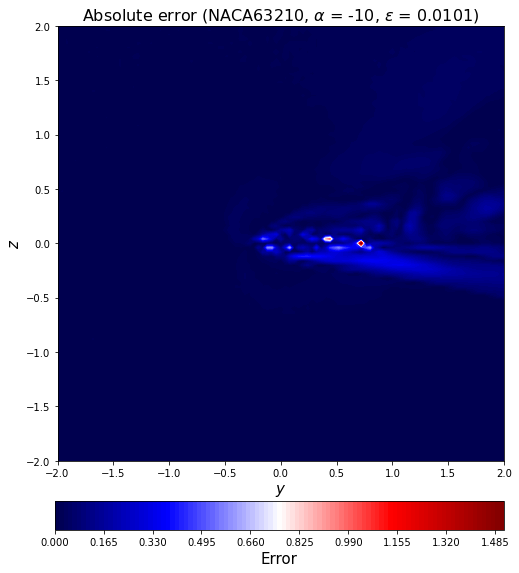

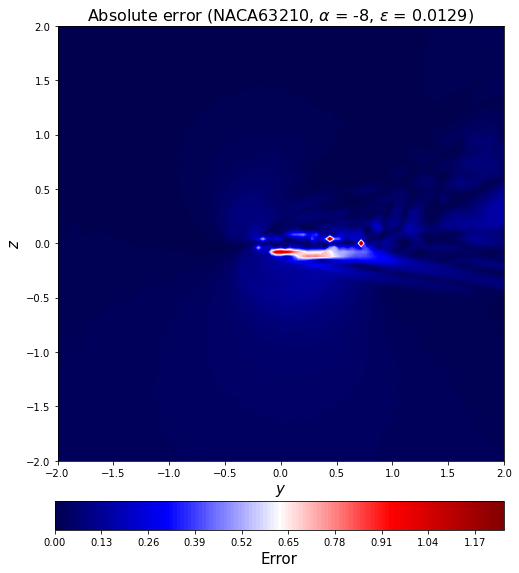

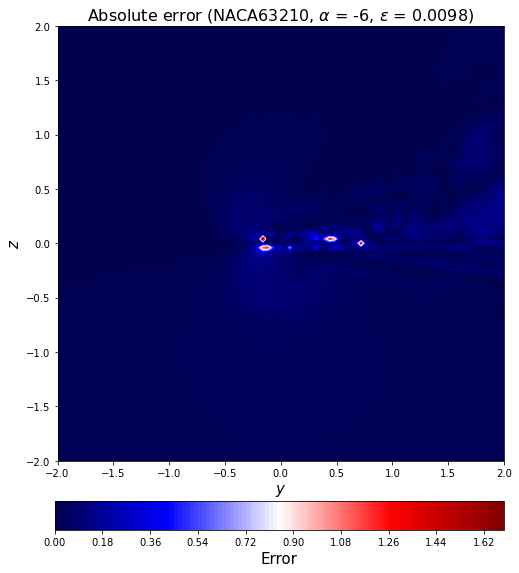

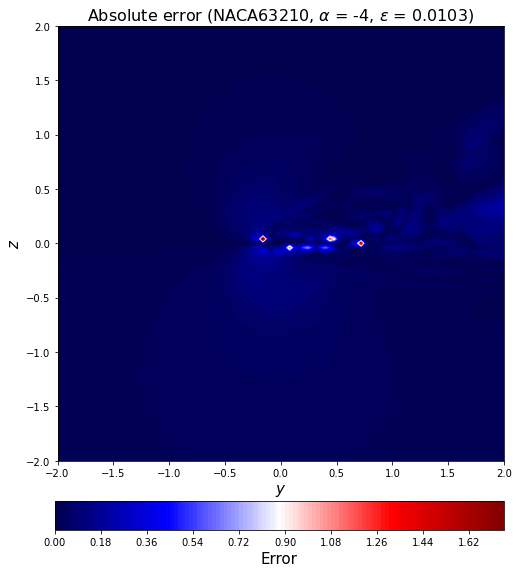

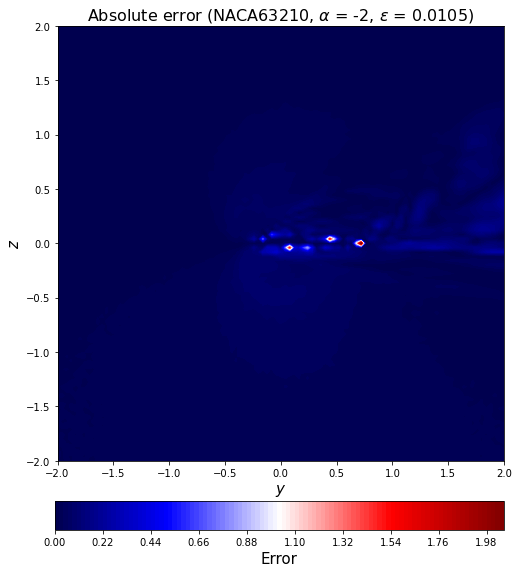

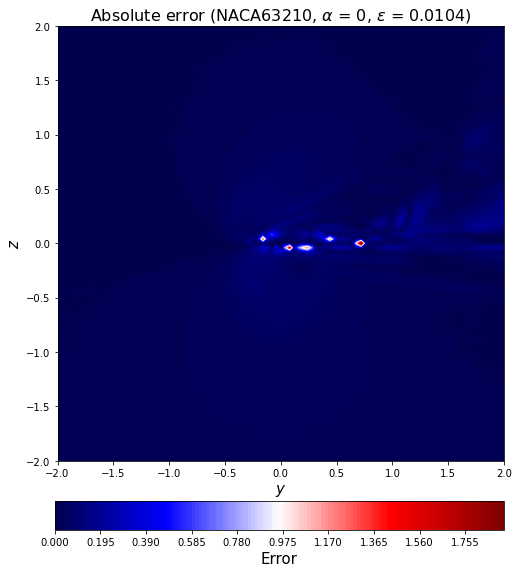

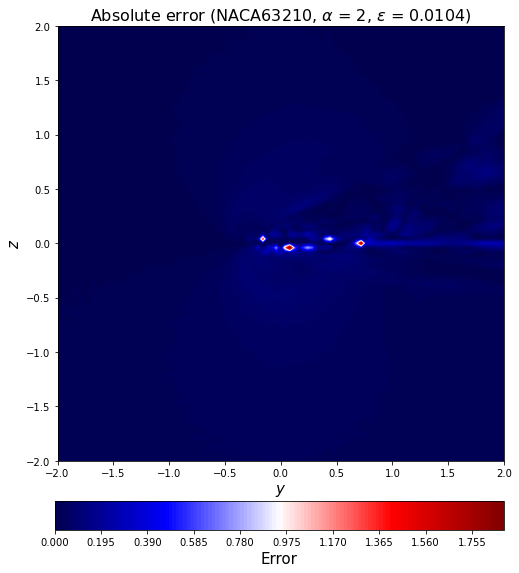

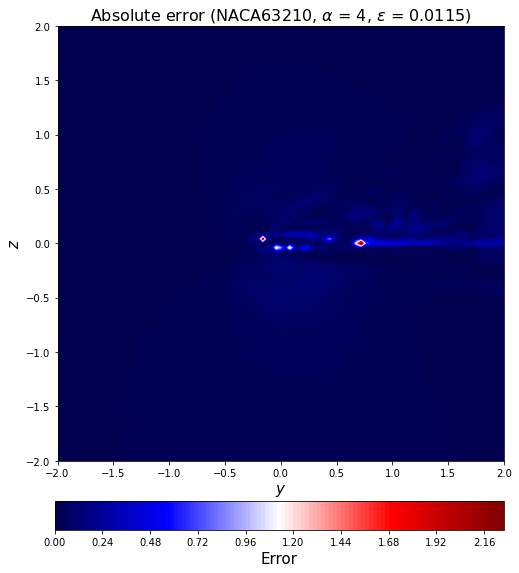

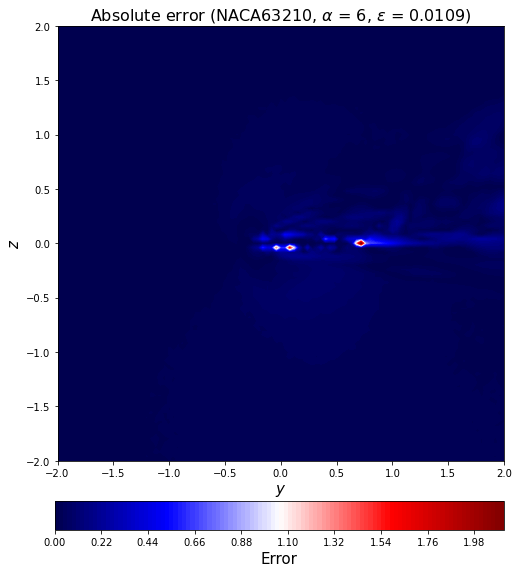

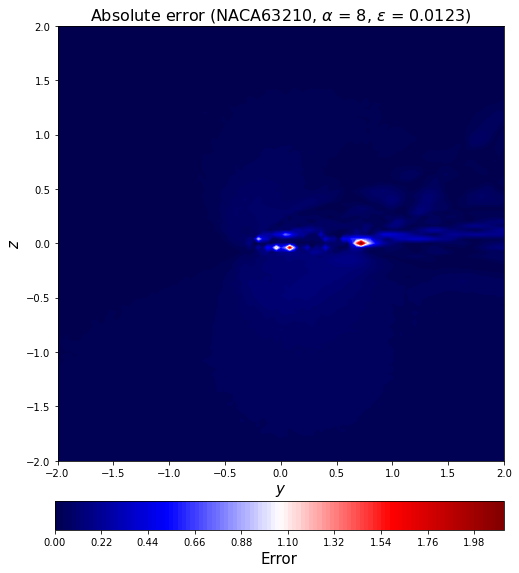

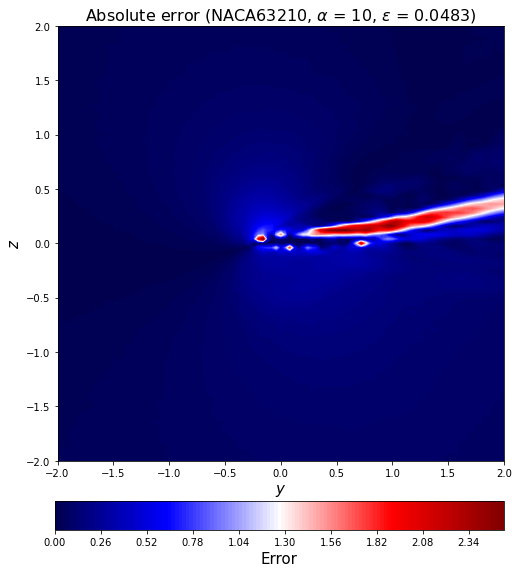

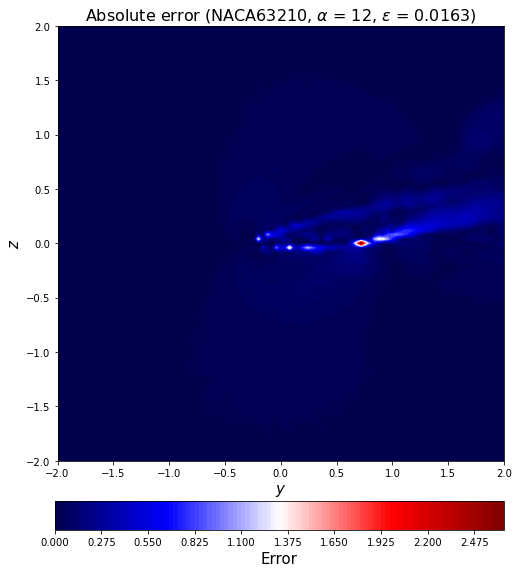

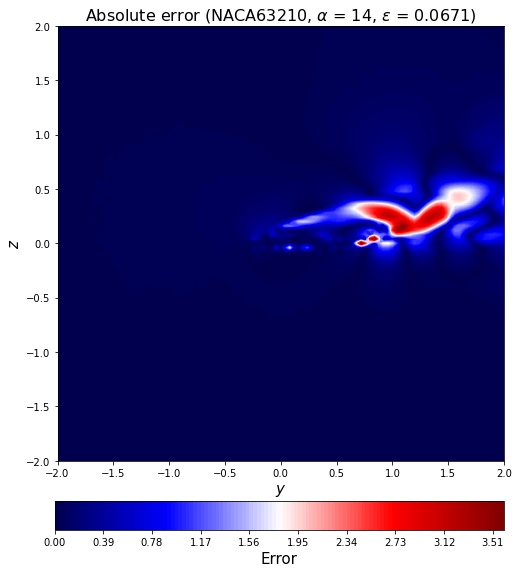

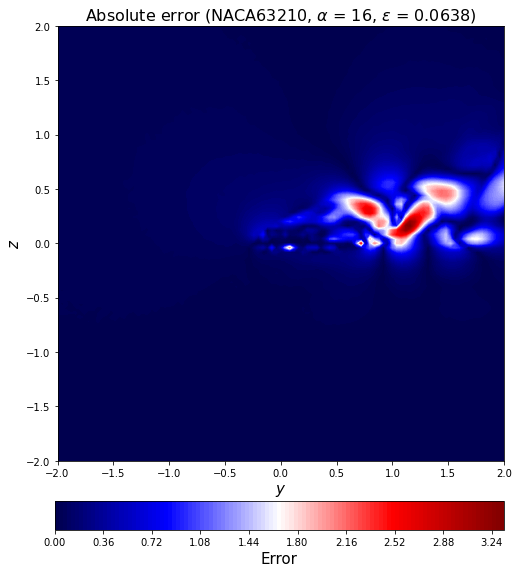

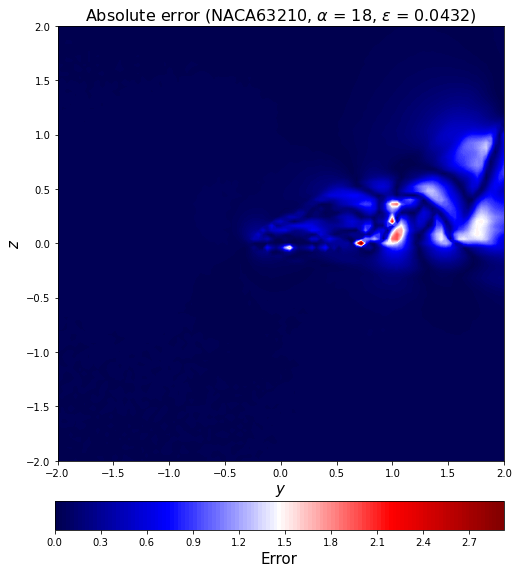

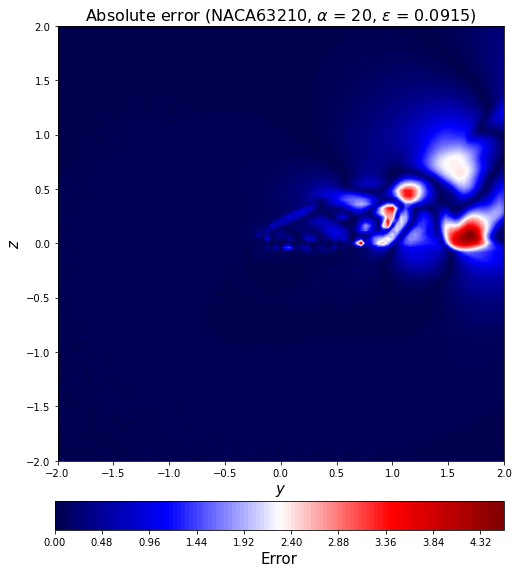

In [62]:
for c in range(0,16):
    error_test_abs2_rotate = error_test_abs[2*16+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[2*16+c])[3:-2],
                                                                       aa_test[2*16+c], l2_error_test_list[2*16+c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

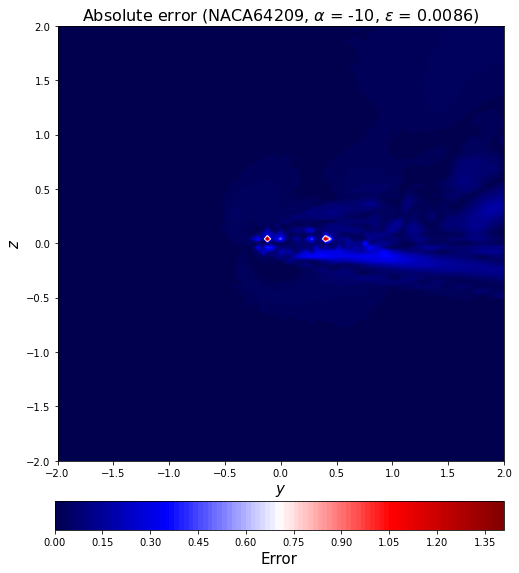

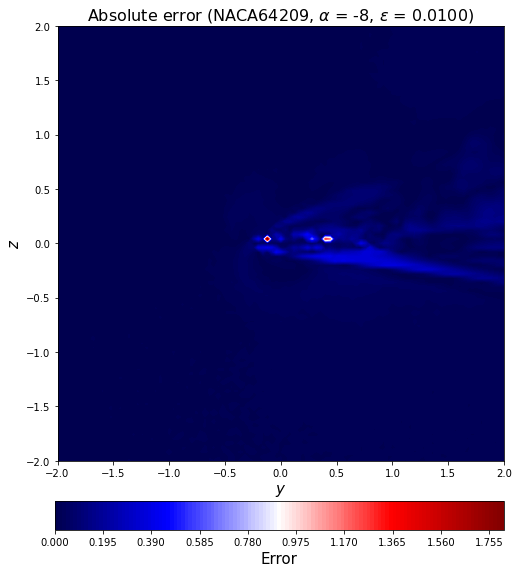

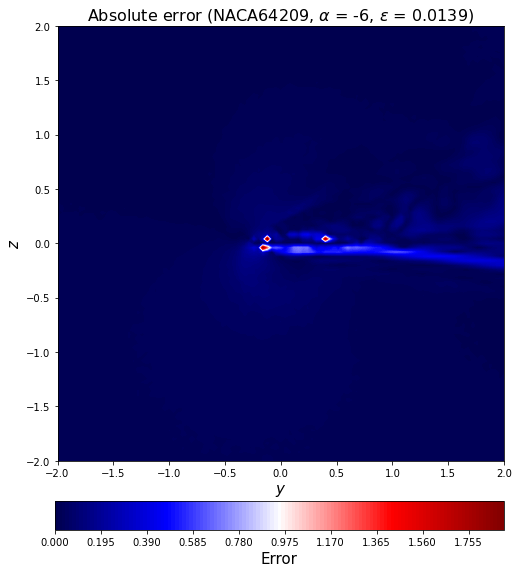

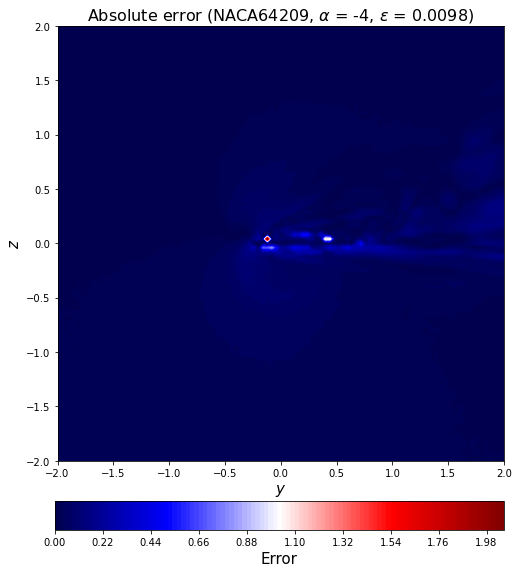

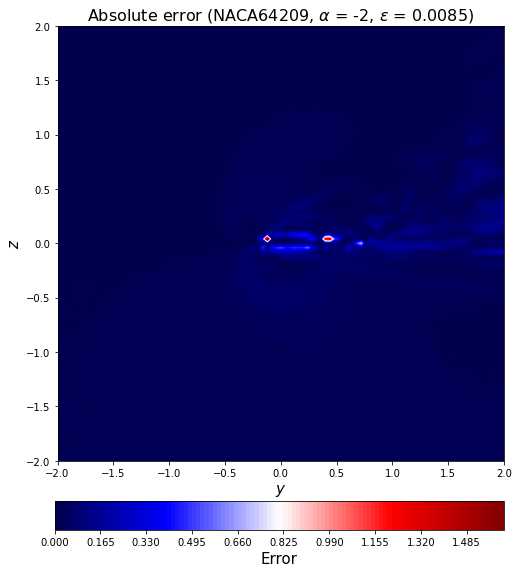

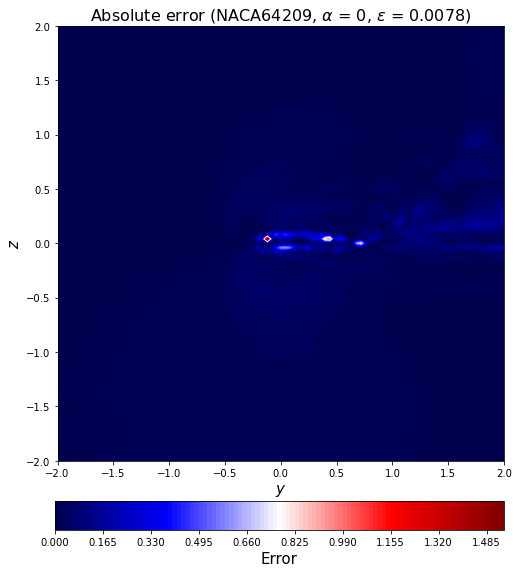

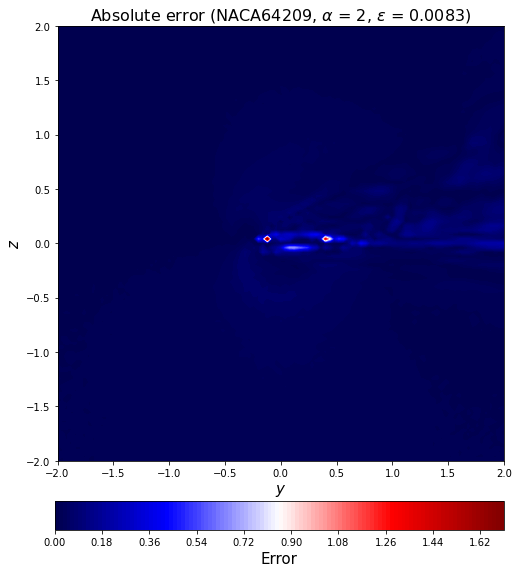

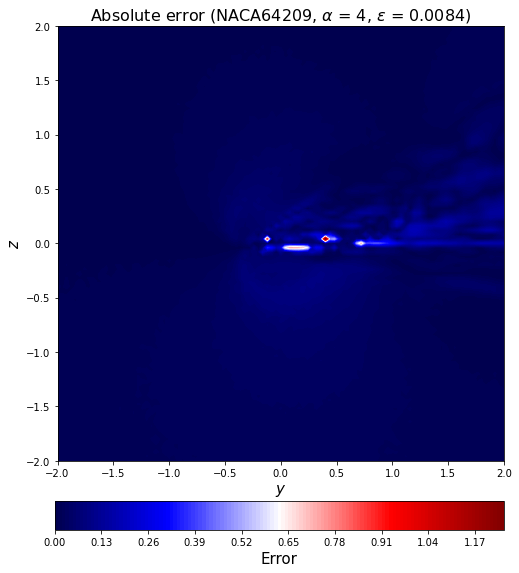

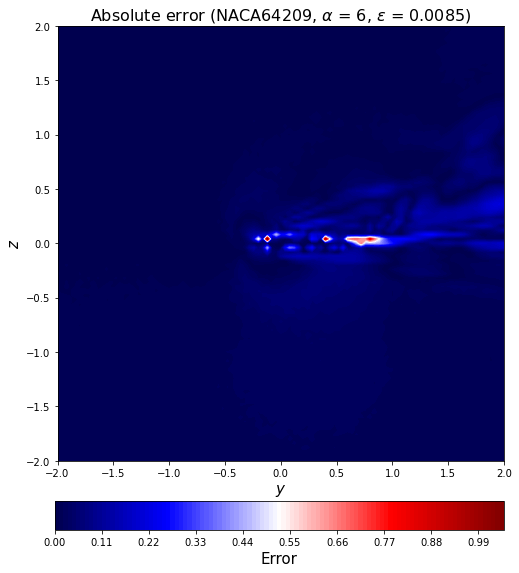

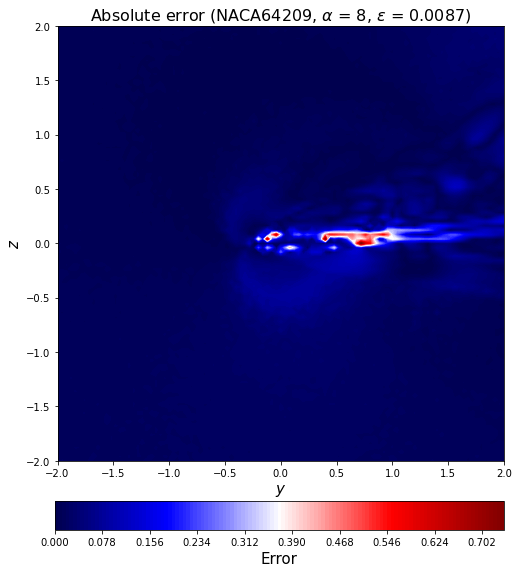

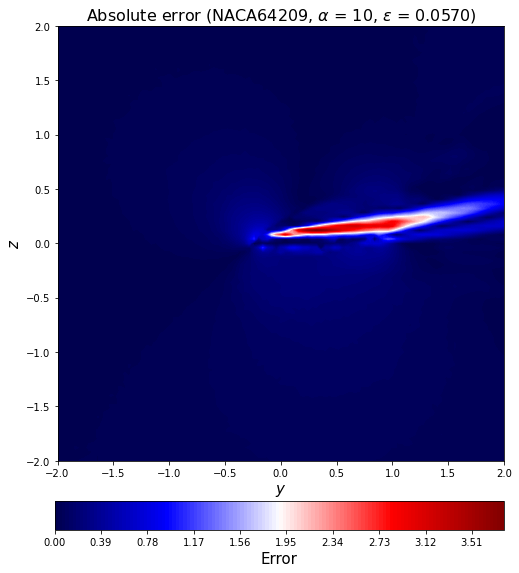

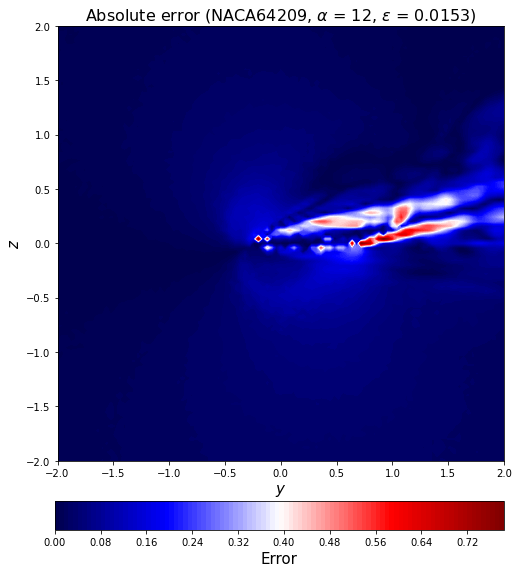

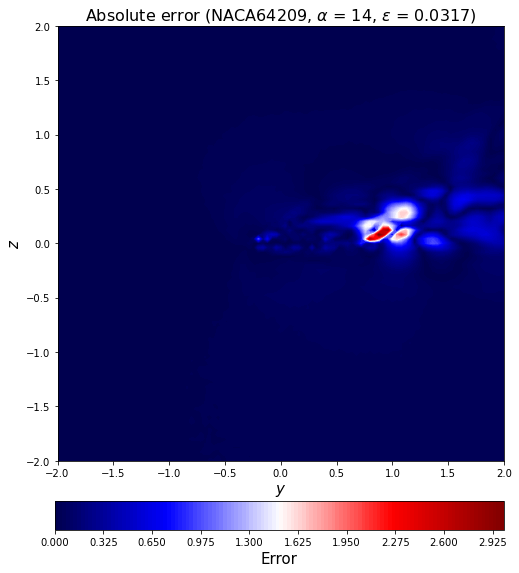

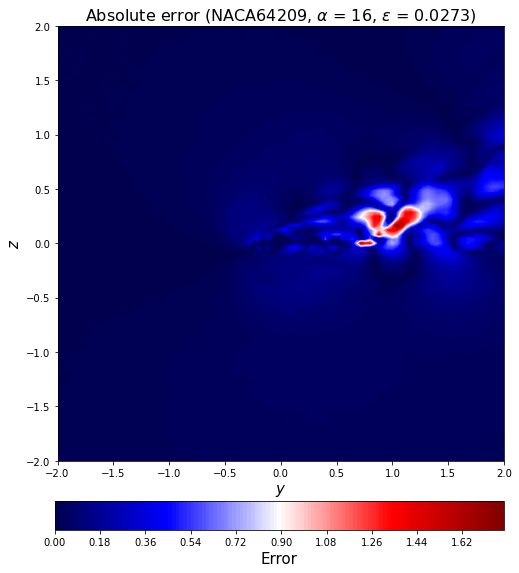

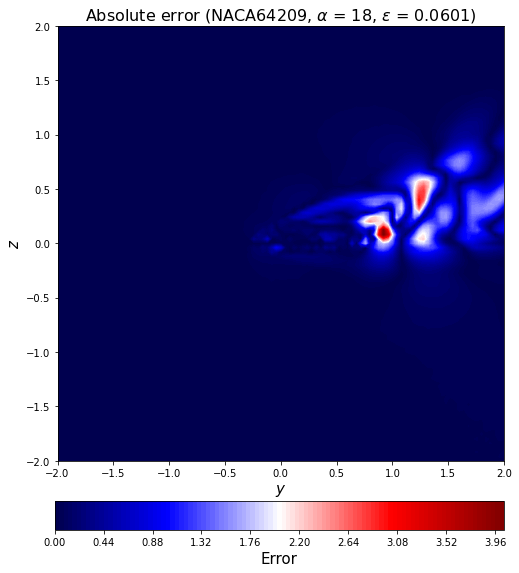

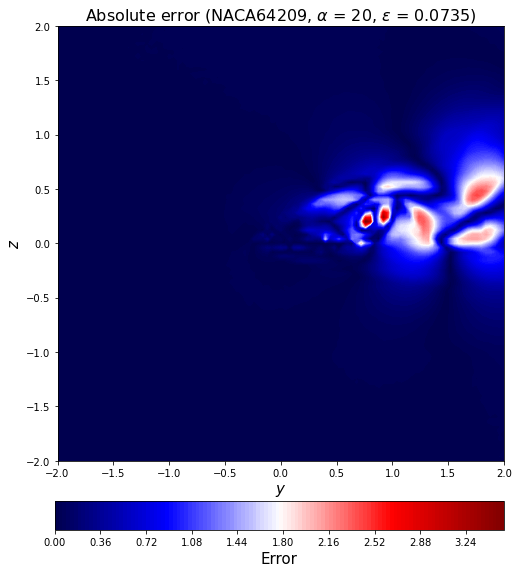

In [63]:
for c in range(0,16):
    error_test_abs2_rotate = error_test_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[c])[3:-2],
                                                                       aa_test[c], l2_error_test_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

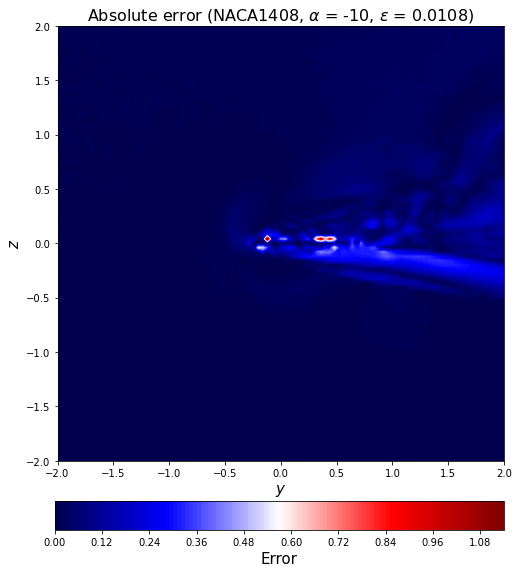

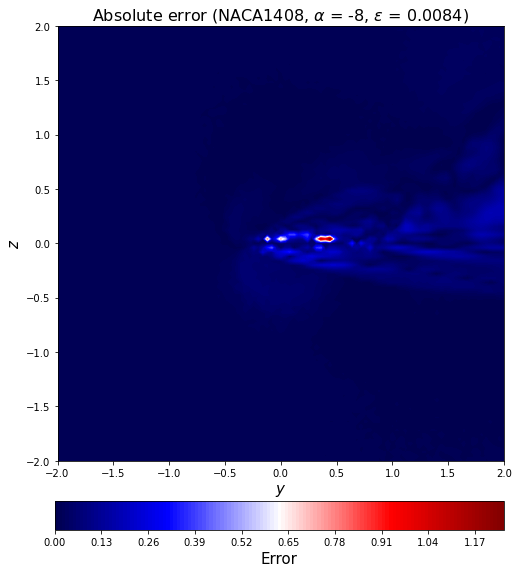

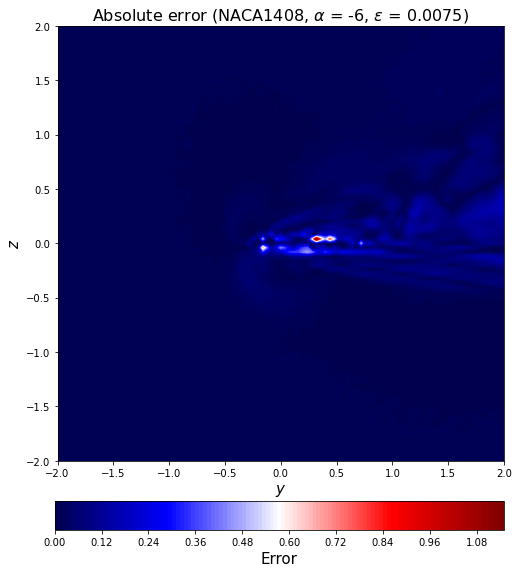

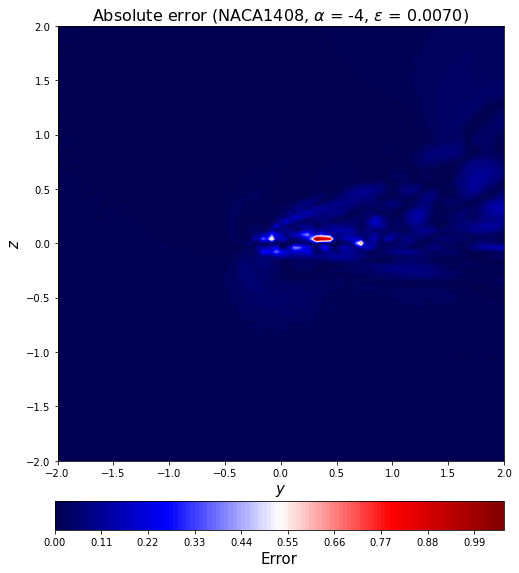

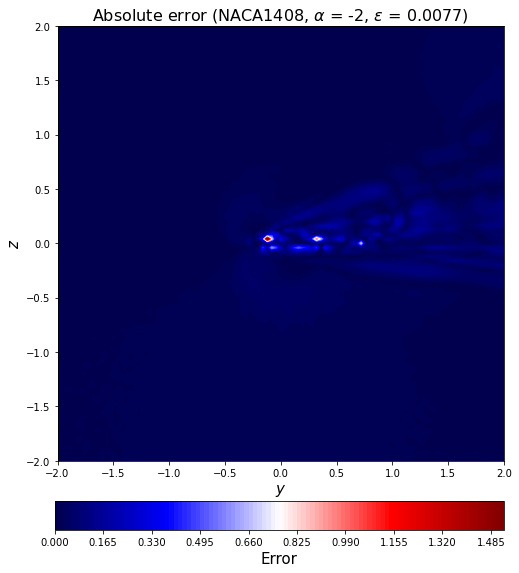

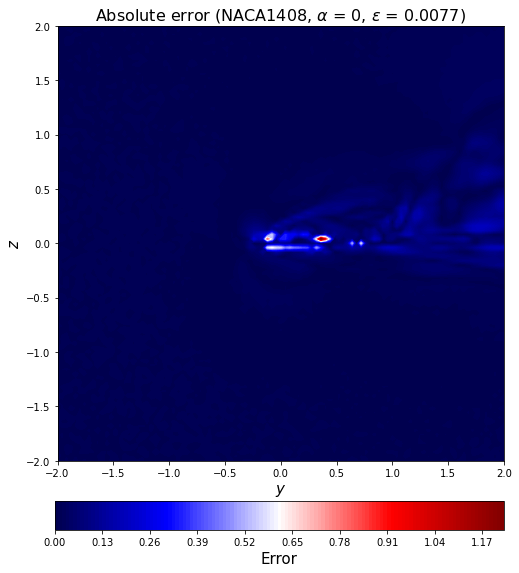

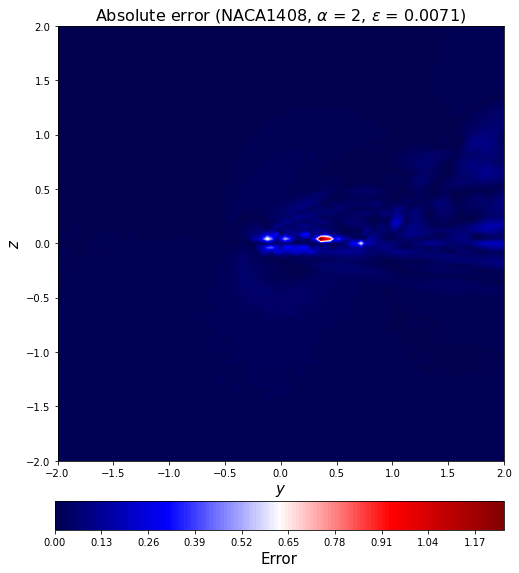

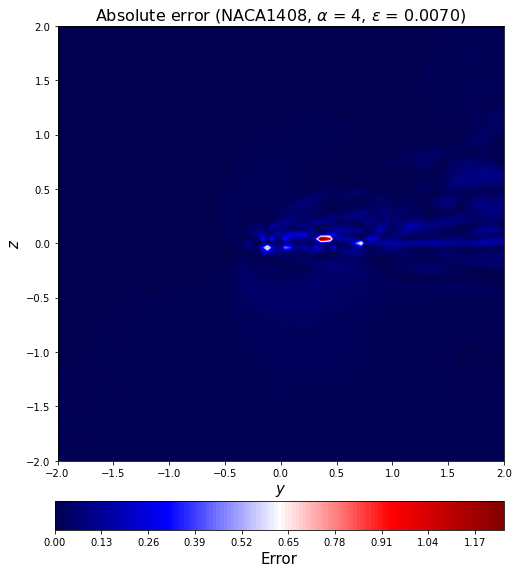

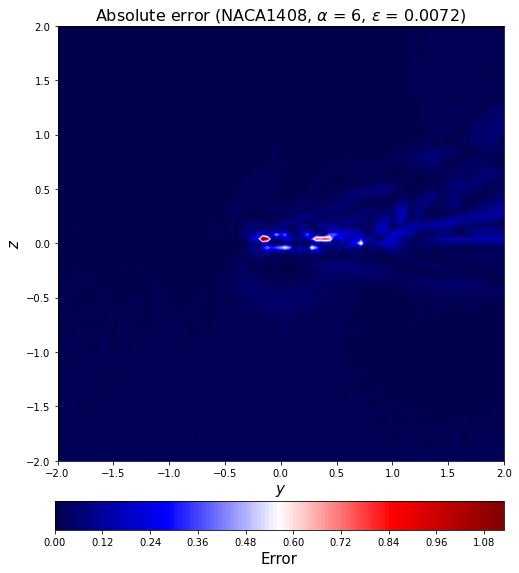

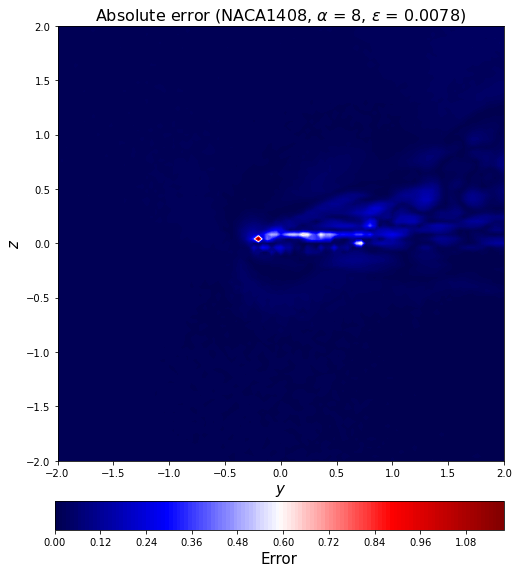

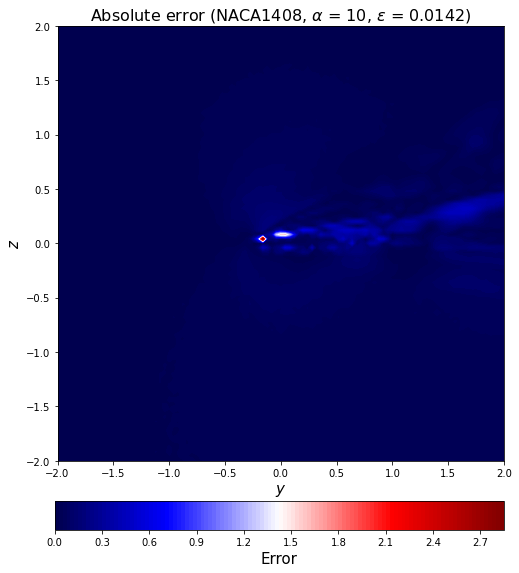

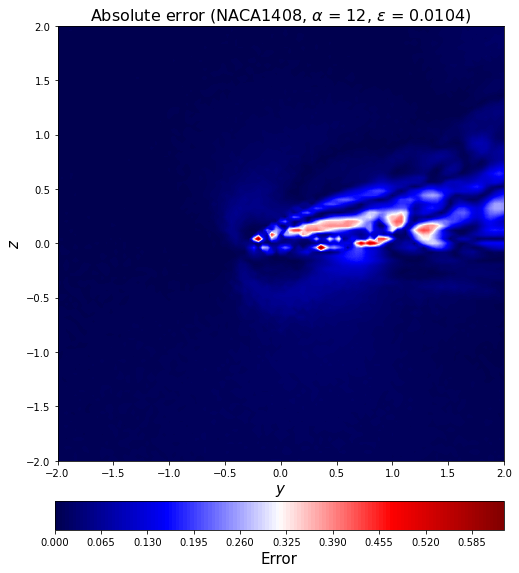

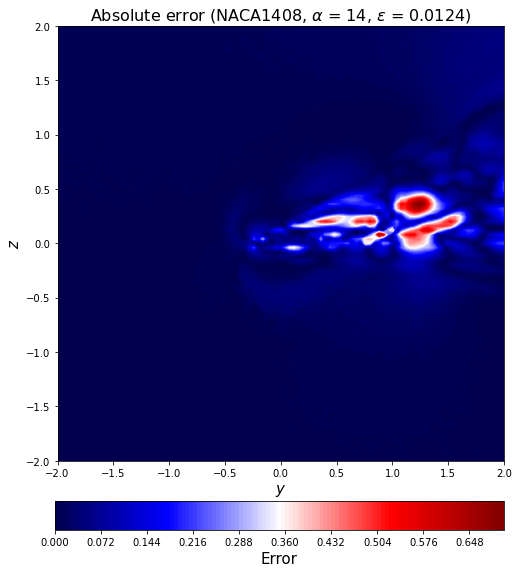

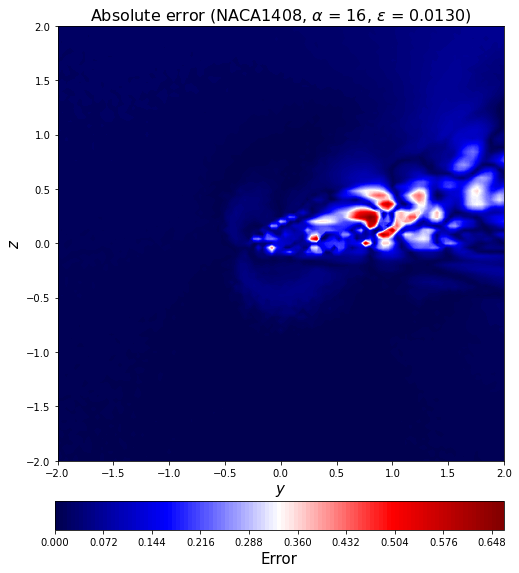

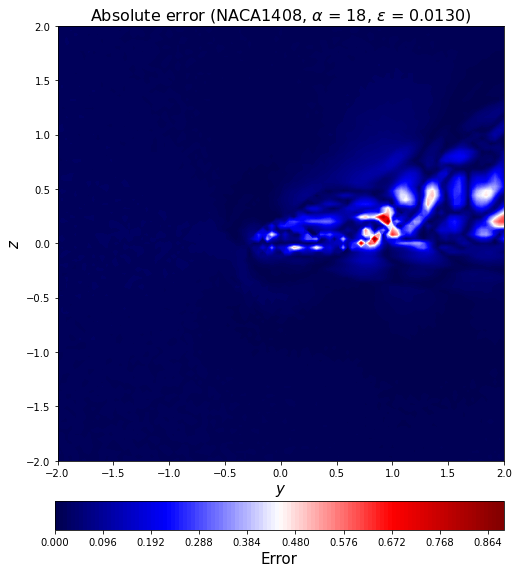

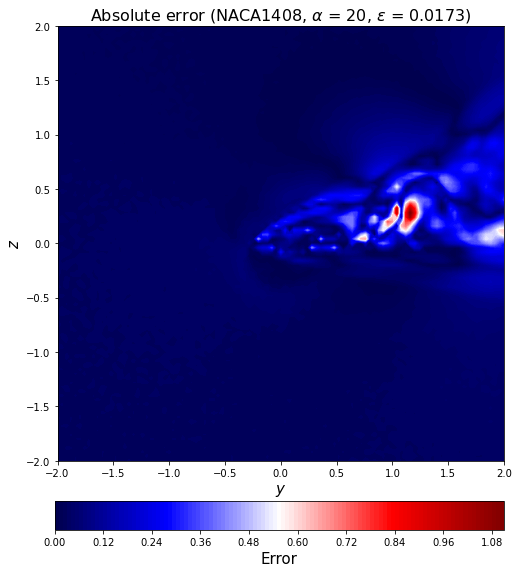

In [64]:
for c in range(0,16):
    error_train_abs2_rotate = error_train_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[c])[3:-2],
                                                                             aa_train[c], l2_error_train_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

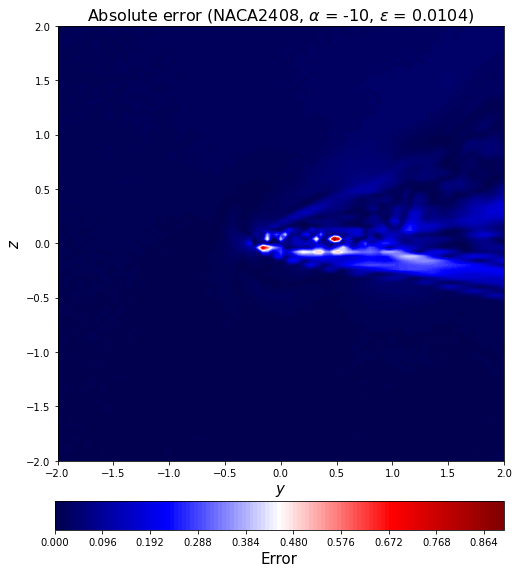

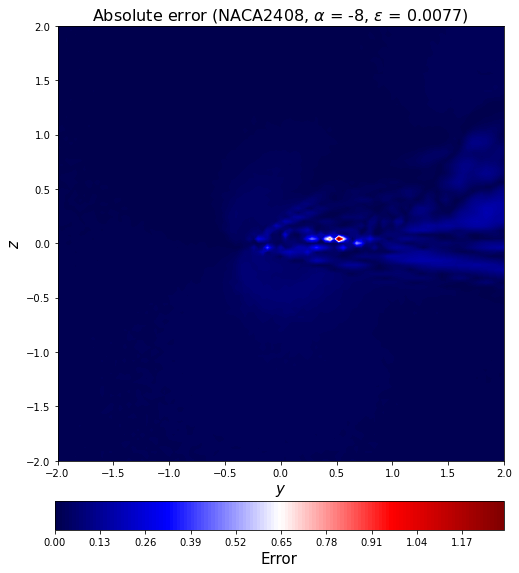

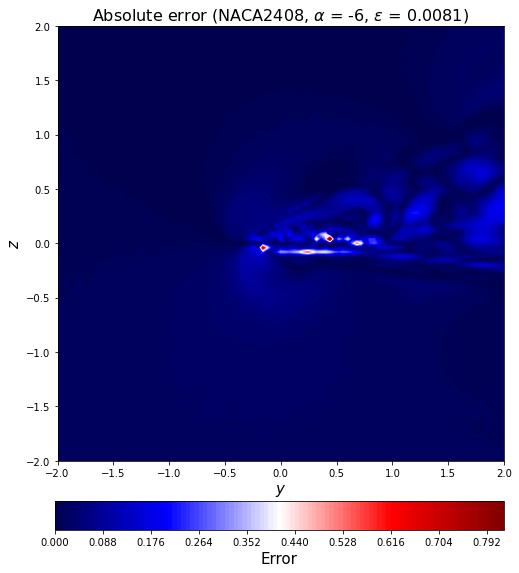

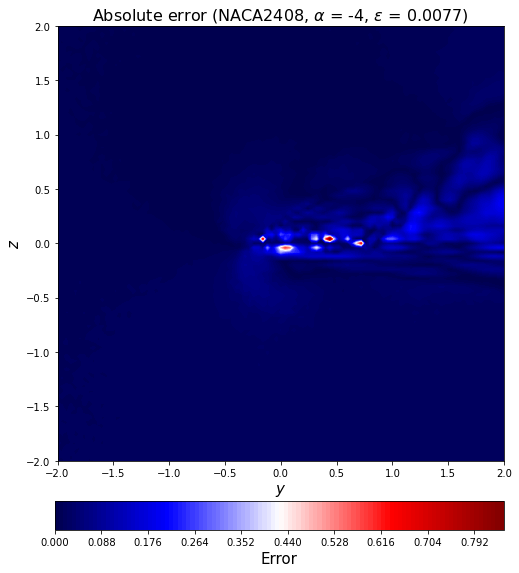

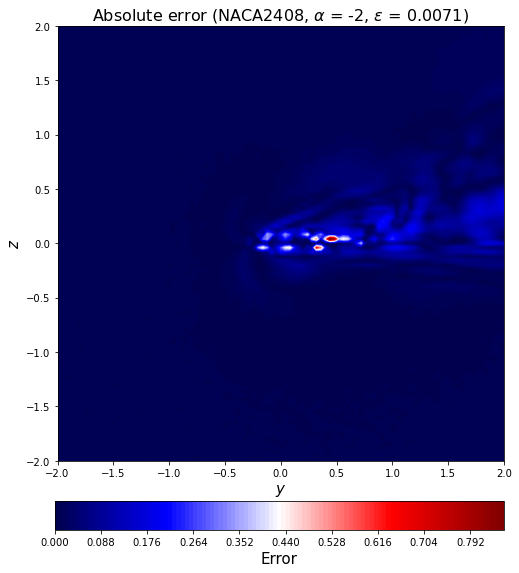

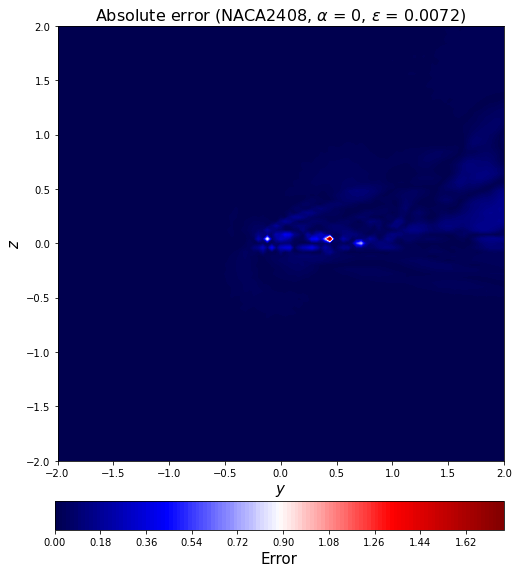

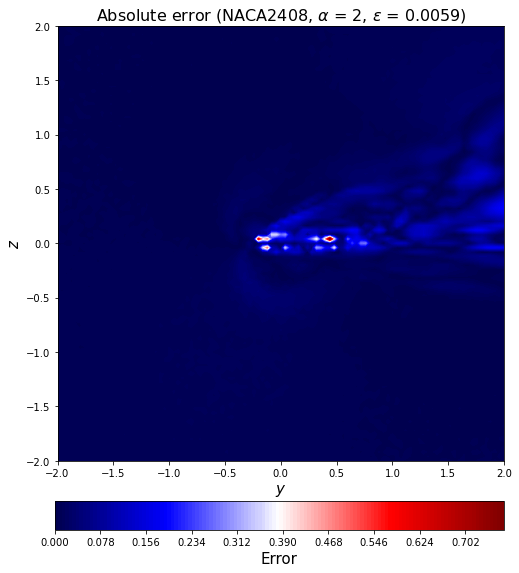

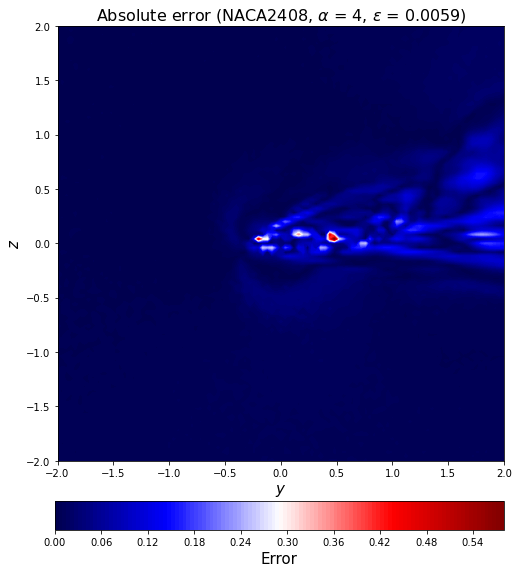

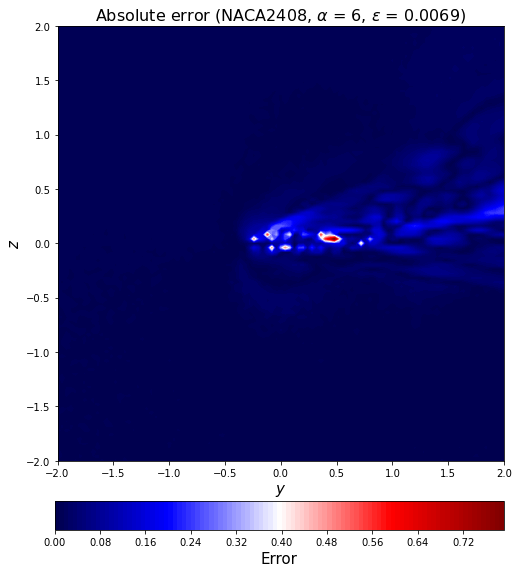

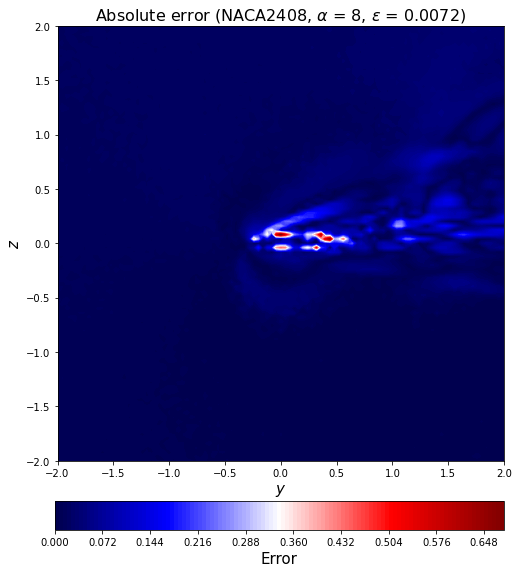

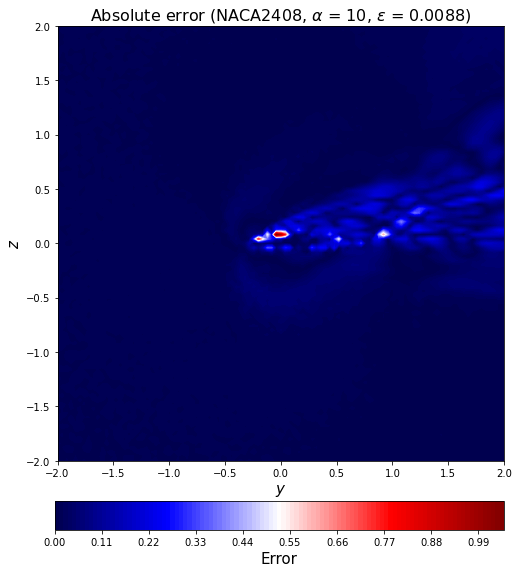

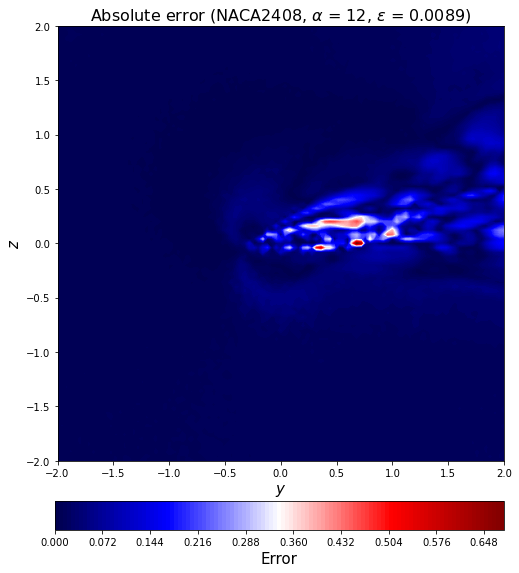

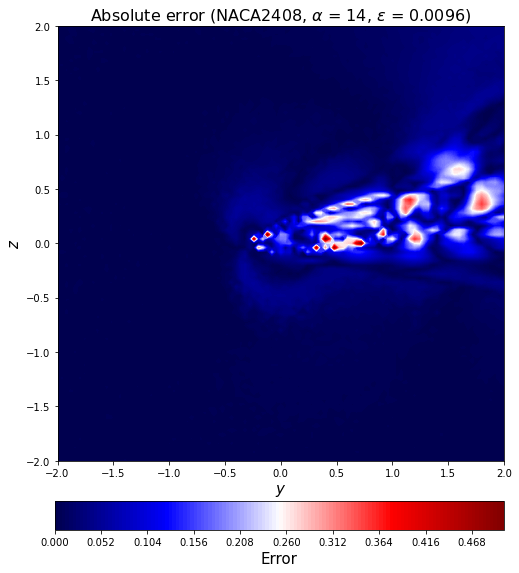

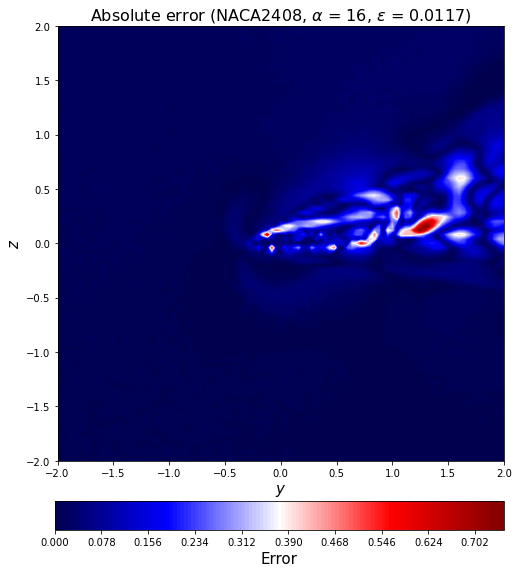

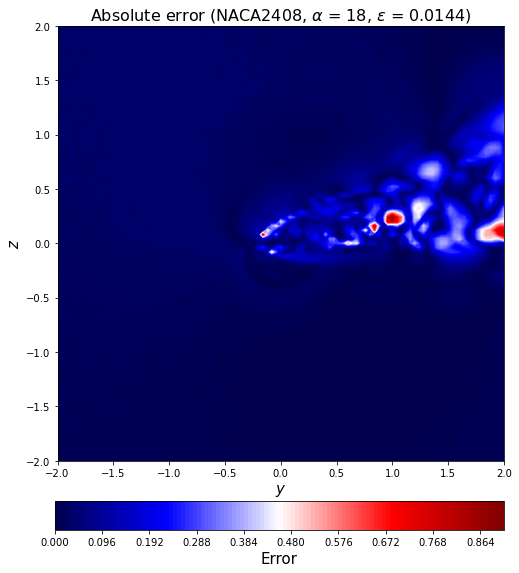

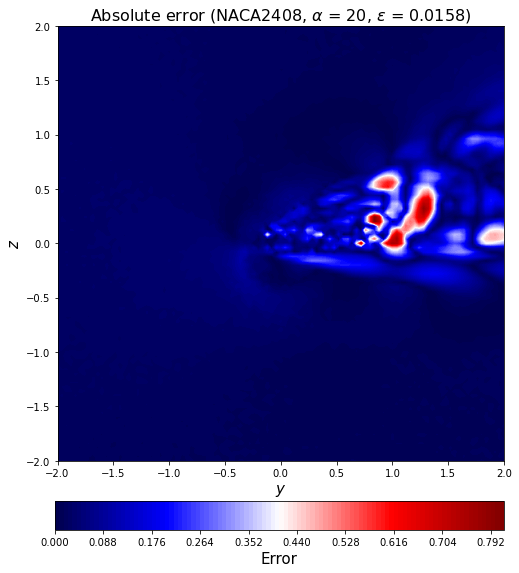

In [65]:
for c in range(0,16):
    error_train_abs2_rotate = error_train_abs[16*20+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[16*20+c])[3:-2],
                                                                             aa_train[16*20+c], l2_error_train_list[16*20+c]),fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    plt.show()

In [66]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig2 = airfoilName_df.iloc[:, 1].values

In [67]:
geometry = geometry.reshape((133, 16, 1))
geometry2 = np.zeros((133*16,1))
geometry2 = geometry2.astype(np.string_)
for i in geometry_orig2:
    index_ = np.where(geometry_orig2==i)
    for j in range(0,16):
        geometry2[16*index_[0]+j,:] = np.asarray(i)

In [68]:
geometry2 = geometry2.reshape((133, 16, 1))

In [69]:
x_train, x_test, geo_train, geo_test, geo_train2, geo_test2 = train_test_split(1-image_np.reshape((133, 16, 100, 100))/1000, geometry, geometry2, test_size=0.05, random_state=1)

In [70]:
geo_train2 = geo_train2.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test2 = geo_test2.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))